# Agricultural Land Area (percentage of total land area)
In this notebook we will predict agricultural land area based on social and governance readiness scores with inspiration from ND-GAIN indicators. 

Overview of the notebook structure.

Data cleaning: 
- Cleaning and assessing agricultural data 
- Combining forest data with Predictor data
- Imputing variables and removing NaN countries 
- Lagging the forest area percentage variable  

Data exploration:
- Exploring correlations with the predictor data 
- Checking for outliers 

Data splitting 
- Splitting the combined dataset in training, validation and testing data
- Checking whether the training split data is a representative sample and not confined to one area of the world.

Data modelling, linear regression:

- Mixed effect linear regression base line models
    - Fitting baseline model (mean model)
    - Fitting simple mixed effects model (time, population)
    
- Mixed effect linear regression theory driven models (social)
    - Social theory driven model 
    - Full social model 

- Mixed effect linear regression theory driven models (governance)
    - Governance theory drive model 
    - Full governance model

Data modelling, random forest:

- Mixed effect random forest social model 
- Mixed effect random forest governance model 
- Mixed effect all predictor model

Model comparison: 
- Compare model predictions 


# Cleaning and combining data 

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns

import pickle as pkl

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [2]:
#Read file 
df = pd.read_excel('Data/agro_sqkm.xlsx')



Removing 0 count countries and non-ISO countries.

In [3]:
summary = df.describe()

# Get the row corresponding to the count statistic
count_row = summary.loc['count']

# Filter for columns where the count is 0.0
columns_with_zero_count = count_row[count_row == 0.0].index.tolist()

#Removing zero count columns from data
df_full = df.drop(columns=columns_with_zero_count)

print(df_full)

                    Country Name Country Code              Indicator Name  \
0                          Aruba          ABW  Agricultural land (sq. km)   
1    Africa Eastern and Southern          AFE  Agricultural land (sq. km)   
2                    Afghanistan          AFG  Agricultural land (sq. km)   
3     Africa Western and Central          AFW  Agricultural land (sq. km)   
4                         Angola          AGO  Agricultural land (sq. km)   
..                           ...          ...                         ...   
261                       Kosovo          XKX  Agricultural land (sq. km)   
262                  Yemen, Rep.          YEM  Agricultural land (sq. km)   
263                 South Africa          ZAF  Agricultural land (sq. km)   
264                       Zambia          ZMB  Agricultural land (sq. km)   
265                     Zimbabwe          ZWE  Agricultural land (sq. km)   

     Indicator Code       1961       1962       1963       1964       1965 

In [4]:
#Removing non countries 

ISO_list = ['AFG', 'ALA', 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'AIA', 'ATA', 'ATG', 'ARG', 'ARM', 'ABW', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BES', 'BIH', 'BWA', 'BVT', 'BRA', 'IOT', 'BRN', 'BGR', 'BFA', 'BDI', 'CPV', 'KHM', 'CMR', 'CAN', 'CYM', 'CAF', 'TCD', 'CHL', 'CHN', 'CXR', 'CCK', 'COL', 'COM', 'COG', 'COD', 'COK', 'CRI', 'CIV', 'HRV', 'CUB', 'CUW', 'CYP', 'CZE', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST', 'SWZ', 'ETH', 'FLK', 'FRO', 'FJI', 'FIN', 'FRA', 'GUF', 'PYF', 'ATF', 'GAB', 'GMB', 'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GLP', 'GUM', 'GTM', 'GGY', 'GIN', 'GNB', 'GUY', 'HTI', 'HMD', 'VAT', 'HND', 'HKG', 'HUN', 'ISL', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL', 'IMN', 'ISR', 'ITA', 'JAM', 'JPN', 'JEY', 'JOR', 'KAZ', 'KEN', 'KIR', 'PRK', 'KOR', 'KWT', 'KGZ', 'LAO', 'LVA', 'LBN', 'LSO', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX', 'MAC', 'MDG', 'MWI', 'MYS', 'MDV', 'MLI', 'MLT', 'MHL', 'MTQ', 'MRT', 'MUS', 'MYT', 'MEX', 'FSM', 'MDA', 'MCO', 'MNG', 'MNE', 'MSR', 'MAR', 'MOZ', 'MMR', 'NAM', 'NRU', 'NPL', 'NLD', 'NCL', 'NZL', 'NIC', 'NER', 'NGA', 'NIU', 'NFK', 'MKD', 'MNP', 'NOR', 'OMN', 'PAK', 'PLW', 'PSE', 'PAN', 'PNG', 'PRY', 'PER', 'PHL', 'PCN', 'POL', 'PRT', 'PRI', 'QAT', 'REU', 'ROU', 'RUS', 'RWA', 'BLM', 'SHN', 'KNA', 'LCA', 'MAF', 'SPM', 'VCT', 'WSM', 'SMR', 'STP', 'SAU', 'SEN', 'SRB', 'SYC', 'SLE', 'SGP', 'SXM', 'SVK', 'SVN', 'SLB', 'SOM', 'ZAF', 'SGS', 'SSD', 'ESP', 'LKA', 'SDN', 'SUR', 'SJM', 'SWE', 'CHE', 'SYR', 'TWN', 'TJK', 'TZA', 'THA', 'TLS', 'TGO', 'TKL', 'TON', 'TTO', 'TUN', 'TUR', 'TKM', 'TCA', 'TUV', 'UGA', 'UKR', 'ARE', 'GBR', 'USA', 'UMI', 'URY', 'UZB', 'VUT', 'VEN', 'VNM', 'VGB', 'VIR', 'WLF', 'ESH', 'YEM', 'ZMB', 'ZWE']

df_iso = df_full[df_full['Country Code'].isin(ISO_list)]


Make the wide df long instead.

In [6]:
#Making df long
melted_df = pd.melt(df_iso, id_vars=['Country Code', 'Country Name', 'Indicator Name', 'Indicator Code'], var_name='Year', value_name='agricultural_land')

melted_df['Year'] = melted_df['Year'].astype(float)

display(melted_df)

,Country Code,Country Name,Indicator Name,Indicator Code,Year,agricultural_land
0,ABW,Aruba,Agricultural land (sq. km),AG.LND.AGRI.K2,1961.0,20.0
1,AFG,Afghanistan,Agricultural land (sq. km),AG.LND.AGRI.K2,1961.0,377500.0
2,AGO,Angola,Agricultural land (sq. km),AG.LND.AGRI.K2,1961.0,451770.0
3,ALB,Albania,Agricultural land (sq. km),AG.LND.AGRI.K2,1961.0,12320.0
4,AND,Andorra,Agricultural land (sq. km),AG.LND.AGRI.K2,1961.0,260.0
...,...,...,...,...,...,...
13110,WSM,Samoa,Agricultural land (sq. km),AG.LND.AGRI.K2,2021.0,494.1
13111,YEM,"Yemen, Rep.",Agricultural land (sq. km),AG.LND.AGRI.K2,2021.0,234520.0
13112,ZAF,South Africa,Agricultural land (sq. km),AG.LND.AGRI.K2,2021.0,963410.0
13113,ZMB,Zambia,Agricultural land (sq. km),AG.LND.AGRI.K2,2021.0,238390.0


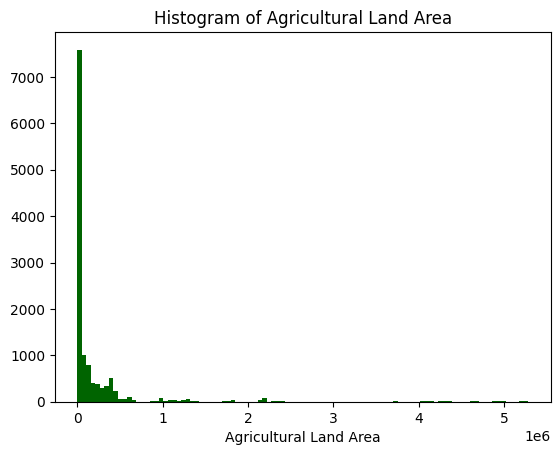

In [7]:
plt.hist(melted_df['agricultural_land'], bins=100, color='darkgreen')
#sns.histplot(data=melted_df, x='forest_area', binwidth=0.1)
plt.title('Histogram of Agricultural Land Area')
plt.xlabel('Agricultural Land Area')
plt.show()

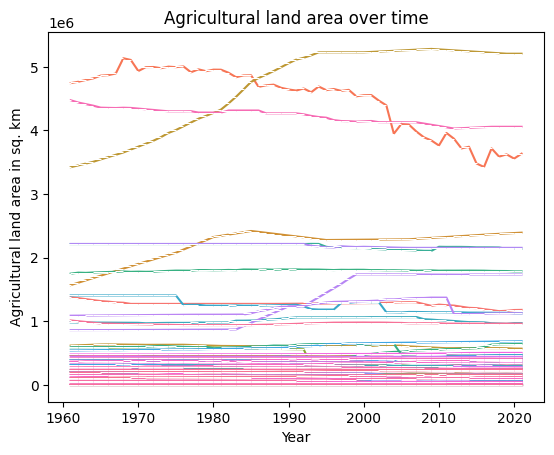

In [9]:
sns.lineplot(data=melted_df, x='Year', y='agricultural_land', hue='Country Name', marker=False, legend=False)

# Add title and labels
plt.title('Agricultural land area over time')
plt.xlabel('Year')
plt.ylabel('Agricultural land area in sq. km')


# Show the plot
plt.show()

### Combine with predictor data 

In [10]:
#Changing name 
agro = melted_df

In [11]:
#Read predictor file 

pred = pd.read_excel('git_data/predictor_data.xlsx')

print(pred)

                           Country Name Country Code  Year  Population, total  \
0                                 Aruba          ABW  1960            54608.0   
1           Africa Eastern and Southern          AFE  1960        130692579.0   
2                           Afghanistan          AFG  1960          8622466.0   
3            Africa Western and Central          AFW  1960         97256290.0   
4                                Angola          AGO  1960          5357195.0   
...                                 ...          ...   ...                ...   
17769                         Swaziland          SWZ  2021                NaN   
17770      Tanzania, United Republic of          TZA  2021                NaN   
17771                            Turkey          TUR  2021                NaN   
17772  Venezuela, Bolivarian Republic o          VEN  2021                NaN   
17773                             Yemen          YEM  2021                NaN   

       Land area (sq. km)  

In [12]:
#Renaming so no double names
agro = agro.rename(columns={'Country Name':'Country'})

#combining forest and pred data
agro_full = pd.merge(agro, pred, on = ['Year', 'Country Code'], how = 'inner')

#removing excess country column
agro_full = agro_full.drop(columns=['Country'])

display(agro_full)

,Country Code,Indicator Name,Indicator Code,Year,agricultural_land,Country Name,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education,Innovation,Social Inequality,ICT,Health
0,ABW,Agricultural land (sq. km),AG.LND.AGRI.K2,1961.0,20.0,Aruba,55811.0,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,Agricultural land (sq. km),AG.LND.AGRI.K2,1961.0,377500.0,Afghanistan,8790140.0,652230.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AGO,Agricultural land (sq. km),AG.LND.AGRI.K2,1961.0,451770.0,Angola,5441333.0,1246700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ALB,Agricultural land (sq. km),AG.LND.AGRI.K2,1961.0,12320.0,Albania,1659800.0,27400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AND,Agricultural land (sq. km),AG.LND.AGRI.K2,1961.0,260.0,Andorra,10216.0,470.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13927,YEM,Agricultural land (sq. km),AG.LND.AGRI.K2,2021.0,234520.0,"Yemen, Rep.",32981641.0,527970.0,-1.680930,-2.580310,-2.324521,-2.040683,-1.802895,-1.668239,NaN,20.0,NaN,16.988239,NaN
13928,YEM,Agricultural land (sq. km),AG.LND.AGRI.K2,2021.0,234520.0,Yemen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.695925
13929,ZAF,Agricultural land (sq. km),AG.LND.AGRI.K2,2021.0,963410.0,South Africa,59392255.0,1213090.0,0.770391,-0.750981,-0.071013,-0.090709,0.069080,-0.034114,25.23908,1804.0,NaN,58.085488,0.422920
13930,ZMB,Agricultural land (sq. km),AG.LND.AGRI.K2,2021.0,238390.0,Zambia,19473125.0,743390.0,-0.369448,0.052348,-0.841102,-0.570348,-0.607838,-0.759728,NaN,13.0,NaN,34.908994,0.762396


Removing countries with all NaN in one column or half of the variables in the columns is NaN.

In [13]:
# Initialize an empty list to store the countries with all NaNs in at least one predictor column
countries_with_all_nans = []
# Initialize an empty list to store the removed countries
removed_countries = []

# Filter the dataset to only include rows where 'Year' is between 1996 and 2020
agro_full_filtered = agro_full[(agro_full['Year'] >= 1996) & (agro_full['Year'] <= 2020)]

#forest_full_filtered.info()

# Identify countries with NaN in forest_area (total of 8 countries)
countries_with_nan = agro_full_filtered[
    (agro_full_filtered['agricultural_land'].isna())
]['Country Code'].unique()

# Filter out these countries from the dataset
agro_full_filtered = agro_full_filtered[~agro_full_filtered['Country Code'].isin(countries_with_nan)]

#Checkin how many countries were removed
print(len(agro_full_filtered['Country Code'].unique()))
print(len(agro_full['Country Code'].unique()))


207
215


In [14]:
# Define the non-predictor columns
non_predictor_columns = [
    'Country Code', 'Country Name', 'Indicator Name', 'Indicator Code', 'Year', 'agricultural_land', 'Education', 'Innovation', 'Social Inequality'
]

# Determine the number of predictors by excluding non-predictor columns
predictor_columns = agro_full_filtered.columns.difference(non_predictor_columns)

# Calculate the threshold (more than half of the predictors)
threshold = len(predictor_columns) / 2

# Filter out rows where more than half of the predictors have NaN values
agro_full_filtered = agro_full_filtered[agro_full_filtered[predictor_columns].isnull().sum(axis=1) <= threshold]

#Checking how many countries were removed
print(len(agro_full_filtered['Country Code'].unique()))
print(len(agro_full['Country Code'].unique()))

195
215


In [15]:
# Loop through each predictor column
for predictor_column in predictor_columns:
    # Group the data by country and check if all values in the current predictor column are NaN
    countries_with_nans = agro_full_filtered.groupby('Country Code')[predictor_column].apply(lambda x: x.isnull().all())
    
    # Add countries with all NaNs in the current predictor column to the list
    countries_with_all_nans.extend(countries_with_nans[countries_with_nans].index.tolist())

# Remove duplicate countries from the list
countries_with_all_nans = list(set(countries_with_all_nans))

# Add removed countries to the list
removed_countries.extend(countries_with_all_nans)

# Remove countries with all NaNs in at least one predictor column from the dataset
agro_full_filtered = agro_full_filtered[~agro_full_filtered['Country Code'].isin(countries_with_all_nans)]

# Display the removed countries
print("Countries removed using country code:", removed_countries)

#Checking how many countries were removed
print(len(agro_full_filtered['Country Code'].unique()))
print(len(agro_full['Country Code'].unique()))

Countries removed using country code: ['BOL', 'BMU', 'VCT', 'KGZ', 'STP', 'GRL', 'FSM', 'ASM', 'KOR', 'HKG', 'IRN', 'PRI', 'MDA', 'BHS', 'VEN', 'CZE', 'GUM', 'YEM', 'SWZ', 'LIE', 'MKD', 'VNM', 'TUR', 'EGY', 'VIR', 'KNA', 'PRK', 'GMB', 'CPV', 'LBY', 'SVK', 'CYM', 'LCA', 'TZA', 'LAO', 'COG', 'ABW', 'CIV']
157
215


In [16]:
print(agro_full_filtered.isna().sum())

Country Code             0
Indicator Name           0
Indicator Code           0
Year                     0
agricultural_land        0
Country Name             0
Population, total        0
Land area (sq. km)      15
WGI VA                   0
WGI PS                  34
WGI GE                  69
WGI RQ                  69
WGI RL                   1
WGI CC                  54
Education             1196
Innovation            1543
Social Inequality     2135
ICT                    797
Health                   0
dtype: int64


We end up with 157 countries and very few NaN in relevant columns. Then we impute the data for each of the countries where at least half of the observations are not NaN.

In [17]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Separate the data by country
grouped_data = agro_full_filtered.groupby('Country Code')

non_predictor_columns = [
    'Country Code', 'Country Name', 'Indicator Name', 'Indicator Code', 'Year', 'agricultural_land', 'Education', 'Innovation', 'Social Inequality'
]

# Initialize an empty list to store imputed data frames
imputed_data_frames = []

# Iterate over each group and perform imputation
for country_code, group in grouped_data:
    # Drop non-predictor columns for imputation
    data_for_imputation = group.drop(columns=non_predictor_columns)

    # Initialize the IterativeImputer
    imputer = IterativeImputer(random_state=42)

    # Fit and transform the imputer on the data
    imputed_data = imputer.fit_transform(data_for_imputation)

    # Print shapes for debugging
    print("Shape of data_for_imputation:", data_for_imputation.shape)
    print("Shape of imputed_data:", imputed_data.shape)

    # Convert the imputed data back to DataFrame
    imputed_group = pd.DataFrame(imputed_data, columns=data_for_imputation.columns)

    # Reset index of the imputed group
    imputed_group.reset_index(drop=True, inplace=True)

    # Merge back the non-predictor columns with the imputed data
    imputed_group = pd.concat([group[non_predictor_columns].reset_index(drop=True), imputed_group], axis=1)

    # Append the imputed group to the list
    imputed_data_frames.append(imputed_group)

# Combine all the imputed data frames into one
agro_full_imputed = pd.concat(imputed_data_frames, ignore_index=True)

# Display the imputed dataset
#display(forest_full_imputed)


Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape 

In [18]:
print(agro_full_imputed.isna().sum())

Country Code             0
Country Name             0
Indicator Name           0
Indicator Code           0
Year                     0
agricultural_land        0
Education             1196
Innovation            1543
Social Inequality     2135
Population, total        0
Land area (sq. km)       0
WGI VA                   0
WGI PS                   0
WGI GE                   0
WGI RQ                   0
WGI RL                   0
WGI CC                   0
ICT                      0
Health                   0
dtype: int64


In [19]:
agro_full_imputed = agro_full_imputed.drop(columns=['Indicator Name', 'Indicator Code', 'Education', 'Innovation', 'Social Inequality'])
agro_full_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3453 entries, 0 to 3452
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country Code        3453 non-null   object 
 1   Country Name        3453 non-null   object 
 2   Year                3453 non-null   float64
 3   agricultural_land   3453 non-null   float64
 4   Population, total   3453 non-null   float64
 5   Land area (sq. km)  3453 non-null   float64
 6   WGI VA              3453 non-null   float64
 7   WGI PS              3453 non-null   float64
 8   WGI GE              3453 non-null   float64
 9   WGI RQ              3453 non-null   float64
 10  WGI RL              3453 non-null   float64
 11  WGI CC              3453 non-null   float64
 12  ICT                 3453 non-null   float64
 13  Health              3453 non-null   float64
dtypes: float64(12), object(2)
memory usage: 377.8+ KB


Delaying the forest area variable.

In [20]:
#Defining the number of years to lag
lag_years = 4

#Creating the new column 'lagged_ghg' and initializing with NaN
agro_full_imputed['lagged_agro'] = pd.NA

#Iterating over each row
for i in range(len(agro_full_imputed)):
    country = agro_full_imputed.loc[i, 'Country Code']
    year = agro_full_imputed.loc[i, 'Year']

    correct_year = year + lag_years
    
    #Finding the row where the country is the same and the year is 'year + lag_years'
    lagged_row = agro_full_imputed[(agro_full_imputed['Country Code'] == country) & (agro_full_imputed['Year'] == correct_year)]
    
    #print(lagged_row['ghg'])
    #If such a row exists, assign its 'Value' to the 'Lagged_Value' of the current row
    if not lagged_row.empty:
        agro_full_imputed.loc[i, 'lagged_agro'] = lagged_row['agricultural_land'].values[0]

#Display the new dataframe 
display(agro_full_imputed)

,Country Code,Country Name,Year,agricultural_land,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,ICT,Health,lagged_agro
0,AFG,Afghanistan,1996.0,377570.0,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,377940.0
1,AFG,Afghanistan,1998.0,378680.0,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,377900.0
2,AFG,Afghanistan,2000.0,377940.0,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,379280.0
3,AFG,Afghanistan,2002.0,377900.0,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,379100.0
4,AFG,Afghanistan,2003.0,378840.0,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,379140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3448,ZWE,Zimbabwe,2016.0,162000.0,14452704.0,386850.0,-1.178460,-0.620810,-1.257999,-1.694922,-1.390663,-1.288441,30.802734,0.714298,162000.0
3449,ZWE,Zimbabwe,2017.0,162000.0,14751101.0,386850.0,-1.195905,-0.710431,-1.282108,-1.583454,-1.396204,-1.298485,32.864358,0.714267,<NA>
3450,ZWE,Zimbabwe,2018.0,162000.0,15052184.0,386850.0,-1.136798,-0.721038,-1.297906,-1.525652,-1.292463,-1.246001,29.632238,0.710913,<NA>
3451,ZWE,Zimbabwe,2019.0,162000.0,15354608.0,386850.0,-1.163669,-0.943286,-1.319774,-1.486515,-1.303515,-1.271190,29.667663,0.710938,<NA>


In [21]:
#Checking if the lagged is correct 
print(agro_full_imputed[(agro_full_imputed['Country Code'] == 'ZWE') & (agro_full_imputed['Year'] == 2000.0)]['agricultural_land'])

print(agro_full_imputed[(agro_full_imputed['Country Code'] == 'ZWE') & (agro_full_imputed['Year'] == 1996.0)]['lagged_agro'])

3433    150600.0
Name: agricultural_land, dtype: float64
3431    150600.0
Name: lagged_agro, dtype: object


In [22]:
agro_full_imputed['lagged_agro'] = pd.to_numeric(agro_full_imputed['lagged_agro'])
agro_full_imputed = agro_full_imputed.rename(columns={'Land area (sq. km)':'land_area'})
agro_full_imputed = agro_full_imputed.rename(columns={'Population, total':'population'})
agro_full_imputed = agro_full_imputed.rename(columns={'WGI VA':'WGI_va'})
agro_full_imputed = agro_full_imputed.rename(columns={'WGI GE':'WGI_ge'})
agro_full_imputed = agro_full_imputed.rename(columns={'WGI RL':'WGI_rl'})
agro_full_imputed = agro_full_imputed.rename(columns={'WGI RQ':'WGI_rq'})
agro_full_imputed = agro_full_imputed.rename(columns={'WGI PS':'WGI_ps'})
agro_full_imputed = agro_full_imputed.rename(columns={'WGI CC':'WGI_cc'})
agro_full_imputed =agro_full_imputed.dropna()

display(agro_full_imputed)

,Country Code,Country Name,Year,agricultural_land,population,land_area,WGI_va,WGI_ps,WGI_ge,WGI_rq,WGI_rl,WGI_cc,ICT,Health,lagged_agro
0,AFG,Afghanistan,1996.0,377570.0,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,377940.0
1,AFG,Afghanistan,1998.0,378680.0,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,377900.0
2,AFG,Afghanistan,2000.0,377940.0,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,379280.0
3,AFG,Afghanistan,2002.0,377900.0,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,379100.0
4,AFG,Afghanistan,2003.0,378840.0,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,379140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,ZWE,Zimbabwe,2012.0,162000.0,13265331.0,386850.0,-1.471968,-0.778662,-1.373752,-1.871891,-1.630184,-1.381803,32.635170,0.640969,162000.0
3445,ZWE,Zimbabwe,2013.0,162000.0,13555422.0,386850.0,-1.386220,-0.665950,-1.308181,-1.854899,-1.587261,-1.419667,34.527992,0.668198,162000.0
3446,ZWE,Zimbabwe,2014.0,162000.0,13855753.0,386850.0,-1.256889,-0.713570,-1.279434,-1.892658,-1.441469,-1.404367,29.543350,0.667720,162000.0
3447,ZWE,Zimbabwe,2015.0,162000.0,14154937.0,386850.0,-1.166087,-0.619207,-1.248707,-1.656233,-1.338473,-1.337617,31.214313,0.692355,162000.0


In [23]:
print(agro_full_imputed.isna().sum())
print(len(agro_full_imputed['Country Code'].unique()))

Country Code         0
Country Name         0
Year                 0
agricultural_land    0
population           0
land_area            0
WGI_va               0
WGI_ps               0
WGI_ge               0
WGI_rq               0
WGI_rl               0
WGI_cc               0
ICT                  0
Health               0
lagged_agro          0
dtype: int64
157


Log transforming to get more normal distributed data.

In [24]:
agro_full_imputed['log_lagged_agro'] = np.log(agro_full_imputed['lagged_agro'])

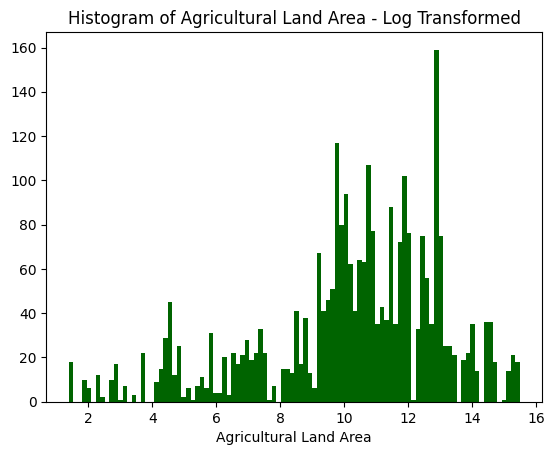

In [26]:
plt.hist(agro_full_imputed['log_lagged_agro'], bins=100, color='darkgreen')
#sns.histplot(data=forest, x='forest_area', binwidth=0.1)
plt.title('Histogram of Agricultural Land Area - Log Transformed')
plt.xlabel('Agricultural Land Area')
plt.show()
plt.show()

In [27]:
agro = agro_full_imputed

agro_size = agro[['Country Code', 'land_area', 'Year']]

agro_group = agro_size.groupby('Country Code')['land_area'].mean()


agro_size_mean = agro_group.reset_index(name='mean_land_area')
display(agro_size_mean)

#Sort forest by population in ascending order
agro_size_mean = agro_size_mean.sort_values(by='mean_land_area', ascending=True).reset_index(drop=True)

agro_size_mean['Size_rank'] = agro_size_mean.index + 1

display(agro_size_mean)

,Country Code,mean_land_area
0,AFG,652230.0
1,AGO,1246700.0
2,ALB,27400.0
3,ARE,71020.0
4,ARG,2736690.0
...,...,...
152,VUT,12190.0
153,WSM,2830.0
154,ZAF,1213090.0
155,ZMB,743390.0


,Country Code,mean_land_area,Size_rank
0,NRU,2.000000e+01,1
1,TUV,3.000000e+01,2
2,SMR,6.000000e+01,3
3,MHL,1.800000e+02,4
4,MDV,3.000000e+02,5
...,...,...,...
152,BRA,8.358140e+06,153
153,CAN,8.965590e+06,154
154,USA,9.154341e+06,155
155,CHN,9.388214e+06,156


In [28]:
#Merging the size rank into ghg again
agro = agro.merge(agro_size_mean[['Country Code', 'Size_rank']], on='Country Code')
display(agro)

,Country Code,Country Name,Year,agricultural_land,population,land_area,WGI_va,WGI_ps,WGI_ge,WGI_rq,WGI_rl,WGI_cc,ICT,Health,lagged_agro,log_lagged_agro,Size_rank
0,AFG,Afghanistan,1996.0,377570.0,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,377940.0,12.842491,126
1,AFG,Afghanistan,1998.0,378680.0,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,377900.0,12.842385,126
2,AFG,Afghanistan,2000.0,377940.0,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,379280.0,12.846030,126
3,AFG,Afghanistan,2002.0,377900.0,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,379100.0,12.845555,126
4,AFG,Afghanistan,2003.0,378840.0,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,379140.0,12.845661,126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2820,ZWE,Zimbabwe,2012.0,162000.0,13265331.0,386850.0,-1.471968,-0.778662,-1.373752,-1.871891,-1.630184,-1.381803,32.635170,0.640969,162000.0,11.995352,108
2821,ZWE,Zimbabwe,2013.0,162000.0,13555422.0,386850.0,-1.386220,-0.665950,-1.308181,-1.854899,-1.587261,-1.419667,34.527992,0.668198,162000.0,11.995352,108
2822,ZWE,Zimbabwe,2014.0,162000.0,13855753.0,386850.0,-1.256889,-0.713570,-1.279434,-1.892658,-1.441469,-1.404367,29.543350,0.667720,162000.0,11.995352,108
2823,ZWE,Zimbabwe,2015.0,162000.0,14154937.0,386850.0,-1.166087,-0.619207,-1.248707,-1.656233,-1.338473,-1.337617,31.214313,0.692355,162000.0,11.995352,108


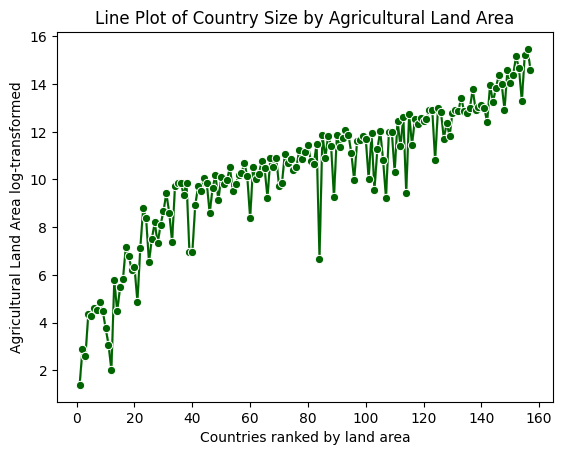

In [29]:
sns.lineplot(x='Size_rank', y='log_lagged_agro', data = agro,marker='o', color='darkgreen')
plt.title('Line Plot of Country Size by Agricultural Land Area')
plt.xlabel('Countries ranked by land area')
plt.ylabel('Agricultural Land Area log-transformed')
plt.show()

### Save combined clean data 

In [30]:
agro.to_csv('git_data/agricultural-modelling.csv', index=False)

# Data exploration

In [31]:
#Load in cleaned data 
agro = pd.read_csv('git_data/agricultural-modelling.csv')

agro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2825 entries, 0 to 2824
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country Code       2825 non-null   object 
 1   Country Name       2825 non-null   object 
 2   Year               2825 non-null   float64
 3   agricultural_land  2825 non-null   float64
 4   population         2825 non-null   float64
 5   land_area          2825 non-null   float64
 6   WGI_va             2825 non-null   float64
 7   WGI_ps             2825 non-null   float64
 8   WGI_ge             2825 non-null   float64
 9   WGI_rq             2825 non-null   float64
 10  WGI_rl             2825 non-null   float64
 11  WGI_cc             2825 non-null   float64
 12  ICT                2825 non-null   float64
 13  Health             2825 non-null   float64
 14  lagged_agro        2825 non-null   float64
 15  log_lagged_agro    2825 non-null   float64
 16  Size_rank          2825 

### Plotting and data exploration

Agro area per country over years.

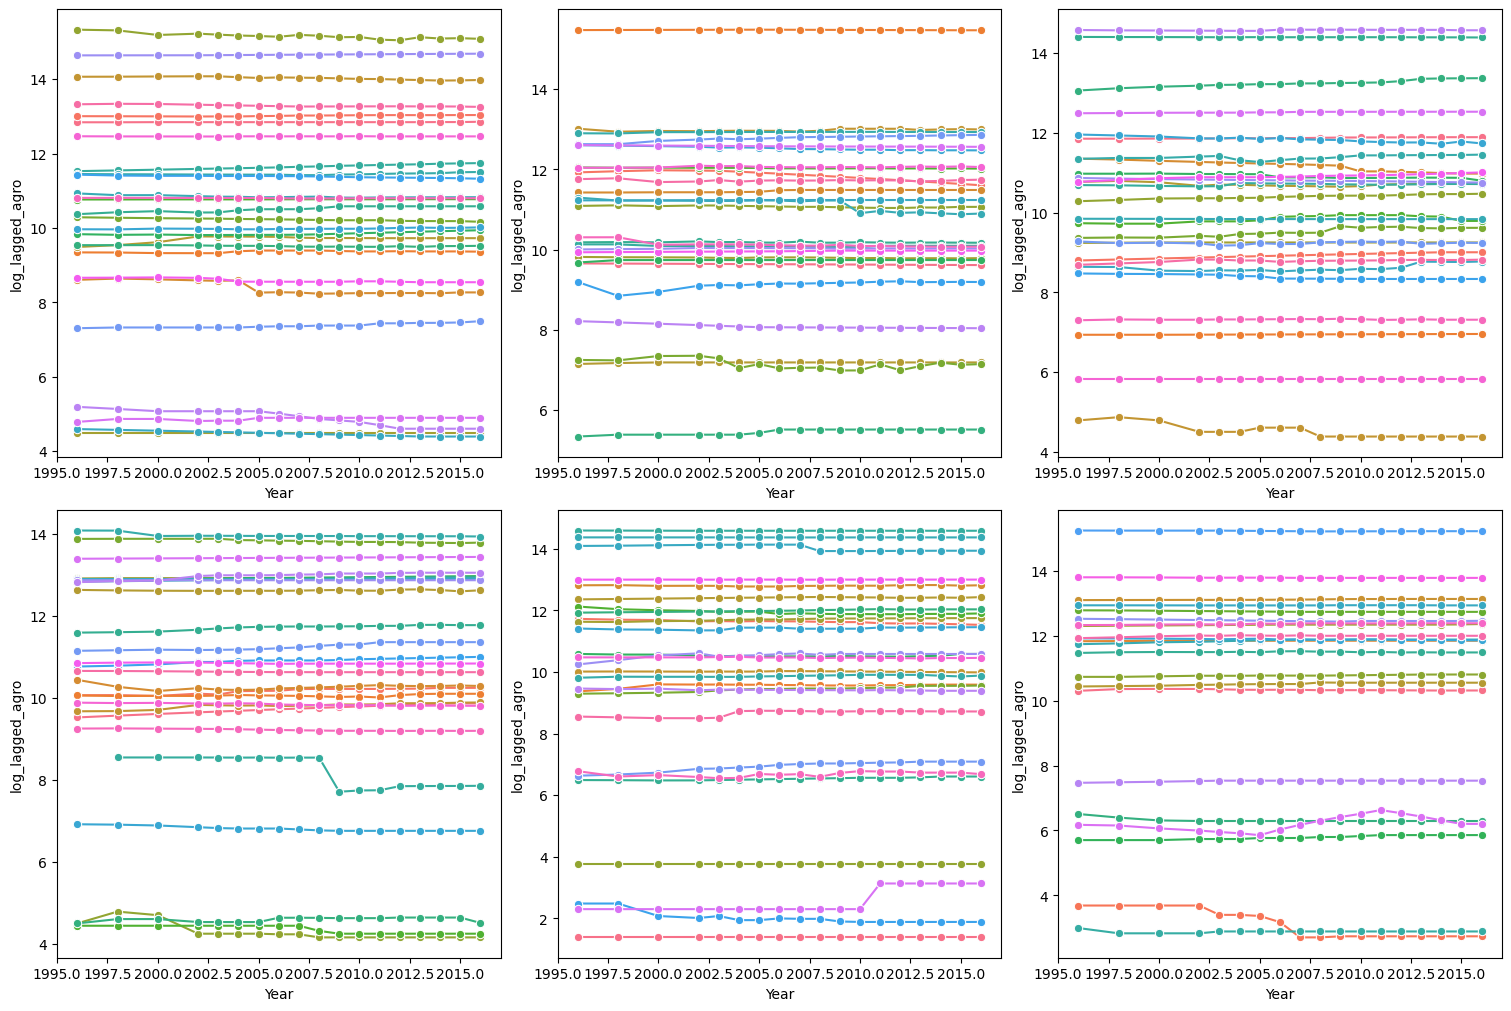

In [35]:
#Dividing by contries
countries = agro['Country Code'].unique()
countries_per_fig = 27
plots_per_row = 3
palette = sns.color_palette("hsv", len(countries))

# Split the countries into groups of the defined size
country_groups = [countries[i:i + countries_per_fig] for i in range(0, len(countries), countries_per_fig)]

num_rows = int(np.ceil(len(country_groups) / plots_per_row))

# Create the grid of plots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows*5), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot the boxplots in the grid
for i, (group, ax) in enumerate(zip(country_groups, axes)):
    data = agro[agro['Country Code'].isin(group)]
    sns.lineplot(x='Year', y='log_lagged_agro', data= data, hue = 'Country Code', marker='o', legend=False, ax=ax)
    #ax.set_title(f'Boxplot of GHG values by Country - Group {i + 1}')
    #ax.set_xlabel('Country Code')
    #ax.set_ylabel('GHG Values')

# If there are any remaining subplots that are empty, hide them
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

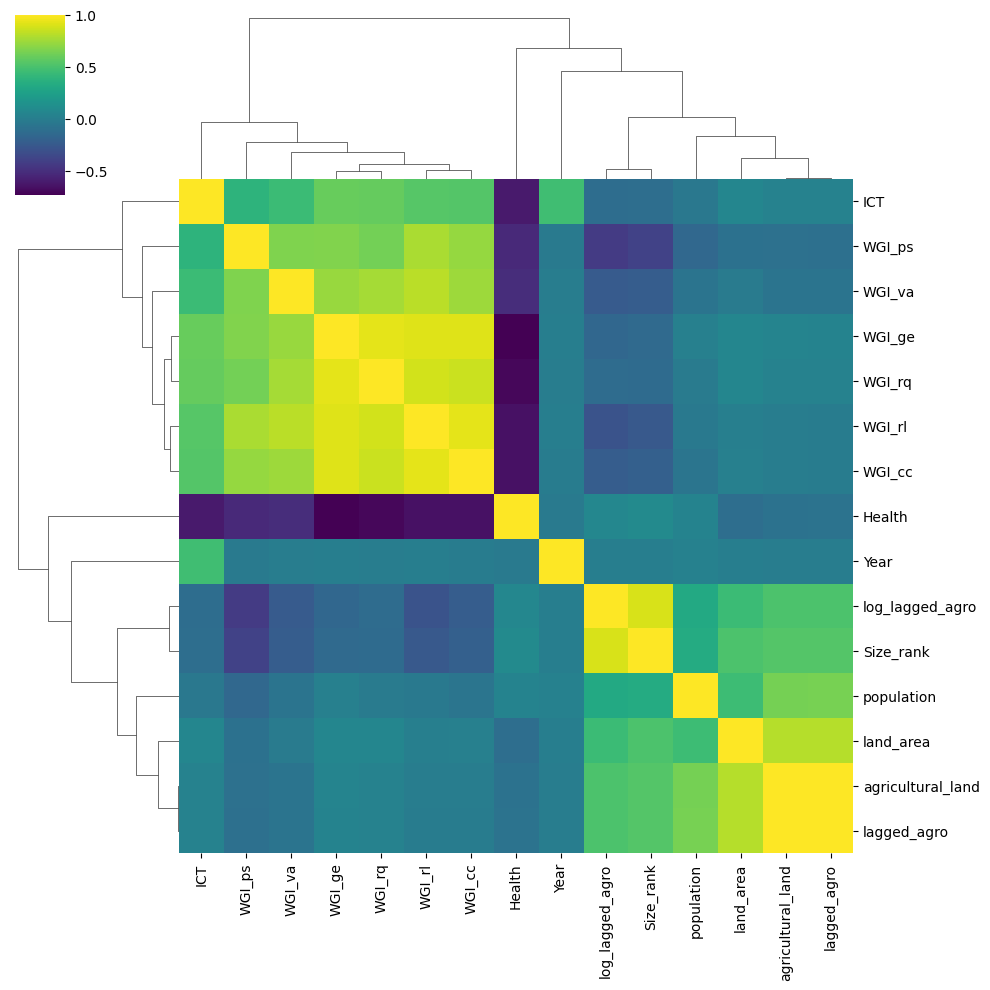

In [36]:
agro_num = agro[agro.select_dtypes(exclude=['object']).columns]

sns.clustermap(agro_num.corr(), cmap='viridis')
plt.show()

### Checking for/Reducing outliers 

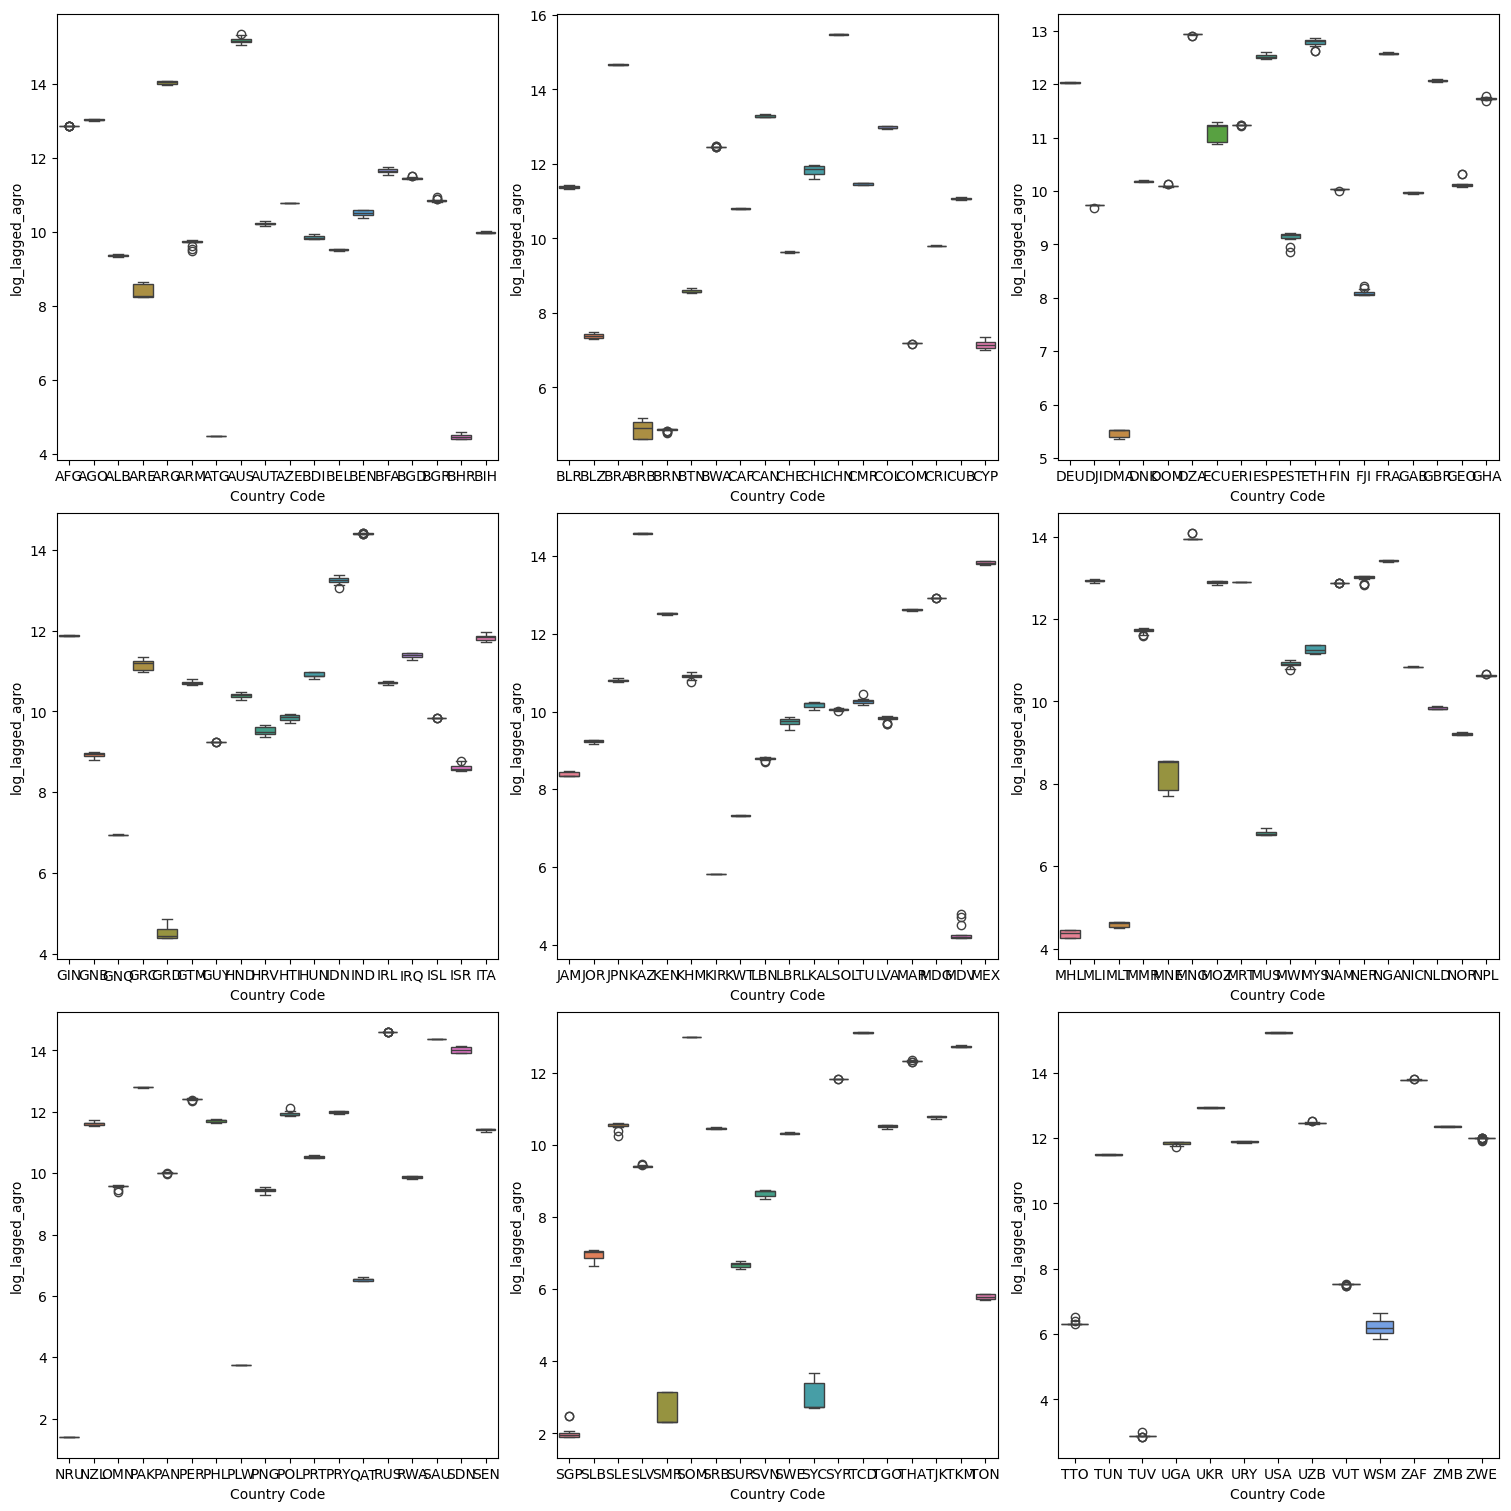

In [37]:
#Dividing by contries
countries = agro['Country Code'].unique()
countries_per_fig = 18
plots_per_row = 3
palette = sns.color_palette("hsv", len(countries))

# Split the countries into groups of the defined size
country_groups = [countries[i:i + countries_per_fig] for i in range(0, len(countries), countries_per_fig)]

num_rows = int(np.ceil(len(country_groups) / plots_per_row))

# Create the grid of plots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows*5), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot the boxplots in the grid
for i, (group, ax) in enumerate(zip(country_groups, axes)):
    data = agro[agro['Country Code'].isin(group)]
    sns.boxplot(x='Country Code', y='log_lagged_agro', data= data, hue = 'Country Code', legend=False, ax=ax)
    #ax.set_title(f'')
    #ax.set_xlabel('')
    #ax.set_ylabel('')

# If there are any remaining subplots that are empty, hide them
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

In [39]:
# Function to detect outliers using IQR method for a given group
def detect_outliers(group):
    Q1 = group['log_lagged_agro'].quantile(0.25)
    Q3 = group['log_lagged_agro'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['log_lagged_agro'] < lower_bound) | (group['log_lagged_agro'] > upper_bound)]

# Detect outliers for each country
outliers = agro.groupby('Country Code').apply(detect_outliers).reset_index(drop=True)

# Get the number of outliers per country
outliers_per_country = outliers.groupby('Country Code').size()

# Function to remove the largest outliers until 4 or fewer remain
def remove_largest_outliers(group):
    if len(group) <= 4:
        return group
    # Sort the outliers by their absolute deviation from the mean
    group['deviation'] = (group['log_lagged_agro'] - group['log_lagged_agro'].mean()).abs()
    group = group.sort_values(by='deviation', ascending=False)
    return group.iloc[4:]  # Keep only the rows after removing the largest outliers

# Remove the largest outliers for each country until 4 or fewer remain
outliers_reduced = outliers.groupby('Country Code').apply(remove_largest_outliers).reset_index(drop=True)

# Total number of remaining outliers
total_outliers_reduced = outliers_reduced.shape[0]
print("\nTotal number of remaining outliers:", total_outliers_reduced)

# Number of remaining outliers per country
remaining_outliers_per_country = outliers_reduced.groupby('Country Code').size()
print("\nNumber of remaining outliers per 'Country Code':")
print(remaining_outliers_per_country)

# Filter the original data to remove the detected outliers
agro = agro[~agro.index.isin(outliers_reduced.index)]

# Display the filtered data
print("\nFiltered data without the largest outliers:")
print(agro)


Total number of remaining outliers: 108

Number of remaining outliers per 'Country Code':
Country Code
AUS    1
BGD    2
BGR    3
BRN    4
BWA    1
COM    2
DJI    1
DOM    2
DZA    2
ERI    3
EST    2
ETH    2
FIN    1
FJI    2
GEO    2
GHA    2
GUY    3
IDN    1
IND    2
ISL    3
ISR    1
KHM    1
LBN    2
LSO    1
LTU    1
LVA    3
MDG    3
MDV    3
MMR    2
MNG    2
MWI    1
NAM    4
NER    3
NPL    2
OMN    2
PAN    2
PER    2
POL    1
RUS    1
SGP    2
SLE    2
SLV    2
SYR    2
THA    3
TTO    3
TUV    4
UGA    1
UZB    2
VUT    4
ZAF    2
ZWE    3
dtype: int64

Filtered data without the largest outliers:
     Country Code         Country Name    Year  agricultural_land  population  \
114           ATG  Antigua and Barbuda  2005.0               90.0     79869.0   
115           ATG  Antigua and Barbuda  2006.0               90.0     80895.0   
116           ATG  Antigua and Barbuda  2007.0               90.0     82016.0   
117           ATG  Antigua and Barbuda  2008.0         

# Data splitting

In [40]:
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [43]:
#Defining the features (X) and the target variable (y)
X = agro.drop(columns=['Country Name', 'lagged_agro', 'agricultural_land']) 
y = agro['log_lagged_agro'] 

#Defining the group variable (Country)
groups = agro['Country Code']

#Initializing the GroupShuffleSplit
gss_outer = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)

#Splitting the data into train and test sets
for train_index, test_index in gss_outer.split(X, y, groups):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    groups_test = groups.iloc[test_index]

    # Further split the test set into two parts
    gss_inner = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)  # Adjust test_size as needed
    for test_index, val_index in gss_inner.split(X_test, y_test, groups_test):
        X_test, X_val = X_test.iloc[test_index], X_test.iloc[val_index]
        y_test, y_val = y_test.iloc[test_index], y_test.iloc[val_index]

In [44]:
# Print the shapes of training and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (1883, 14) (1883,)
Validation set shape: (414, 14) (414,)
Test set shape: (414, 14) (414,)


Checking training data for representative sample. 

In [45]:
#Plotting the size rank for each split 

val = X_val['Size_rank']
test = X_test['Size_rank']
train = X_train['Size_rank']

size_df = pd.DataFrame({
    'val': val,
    'test': test,
    'train': train
})


size_df = pd.melt(size_df)
display(size_df)


,variable,value
0,val,NaN
1,val,NaN
2,val,NaN
3,val,NaN
4,val,NaN
...,...,...
8128,train,108.0
8129,train,108.0
8130,train,108.0
8131,train,108.0


Finish plot:

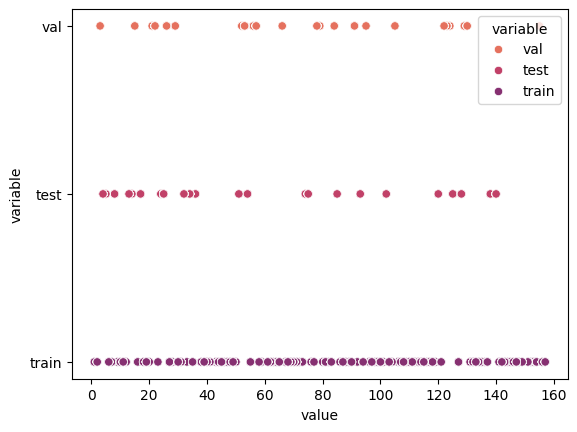

In [46]:
sns.scatterplot(data=size_df, 
                y='variable', 
                x='value', 
                marker='o', 
                hue='variable', palette='flare')
plt.show()

# Data modelling

In [47]:
performances = []

## Baseline Median Dummy Model 

- **Data Preparation:**
  - Import necessary libraries for numerical computations and model evaluation.
  - Convert the 'lagged_ghg' column in the dataset (`ghg_model`) to numeric data type.
  - Define a function `detect_outliers` to identify outliers using the Interquartile Range (IQR) method within each group of data.
  - Apply the outlier detection function to group the data by 'Country Code' and identify outliers.
  - Print the total number of outliers and the number of outliers per country.
  
- **Data Splitting:**
  - Define features (`X`) and the target variable (`y`) by excluding certain columns from the dataset.
  - Define the grouping variable (`groups`) based on 'Country Code'.
  - Initialize a GroupShuffleSplit object (`gss_outer`) to split the data into training and test sets while preserving groups.
  - Split the data into training and test sets, and further split the test set into validation and test sets using nested GroupShuffleSplit objects.
  - Print the shapes of the training, validation, and test sets.

- **Model Evaluation:**
  - Initialize a list (`performances`) to store performance metrics.
  - For each data split (train, val, test):
    - Calculate the median of 'lagged_ghg' for each country in the current split.
    - Merge the median values back to the current data split.
    - Use the median 'lagged_ghg' as predictions for the baseline model.
    - Calculate performance metrics (MAE, RMSE, MAPE, R2) for the baseline model on the current data split and append them to the `performances` list.

- **Performance Visualization:**
  - Print the performance metrics (MAE, RMSE, MAPE, R2) for each model split.
  - Visualize the performance metrics using scatterplots sorted by RMSE, MAPE, MAE, and R2 for each model split.

In [48]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import pickle as pkl
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [49]:
# Calculate median lagged_agro for X_train
median_lagged_agro_train = X_train['log_lagged_agro'].median()

# Function to add median values to a dataset
def add_median_values(df, median_value):
    df['median_prediction'] = median_value
    return df

# List of datasets to process
datasets = [(X_train, 'X_train'), (X_val, 'X_val'), (X_test, 'X_test')]

# Iterate over the datasets and add the median values
for x, name in datasets:
    x = add_median_values(x, median_lagged_agro_train)

# Now X_train, X_val, and X_test have the new column 'median_lagged_agro'


C:\Users\marc1\AppData\Local\Temp\ipykernel_5184\3379224918.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['median_prediction'] = median_value


In [50]:
sorted_X_val = X_val.sort_values(by='Country Code')
display(sorted_X_val)


,Country Code,Year,population,land_area,WGI_va,WGI_ps,WGI_ge,WGI_rq,WGI_rl,WGI_cc,ICT,Health,log_lagged_agro,Size_rank,median_prediction
306,BIH,1996.0,3907751.0,51200.0,-0.103826,-0.594428,-1.192046,-0.910771,-0.241687,-0.270570,30.115971,0.441583,9.966462,52,10.774676
323,BIH,2016.0,3480986.0,51200.0,-0.131173,-0.402664,-0.451146,-0.139021,-0.191817,-0.485801,46.449809,0.355935,10.017709,52,10.774676
322,BIH,2015.0,3524324.0,51200.0,-0.098089,-0.404168,-0.623982,-0.184997,-0.264293,-0.417168,46.006572,0.363443,10.006044,52,10.774676
321,BIH,2014.0,3571068.0,51200.0,-0.070961,-0.019179,-0.490967,-0.041673,-0.132223,-0.299685,45.577486,0.359321,10.003785,52,10.774676
320,BIH,2013.0,3617559.0,51200.0,-0.116463,-0.404944,-0.432593,-0.074899,-0.139309,-0.244403,45.113720,0.368110,10.011445,52,10.774676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2736,VUT,1998.0,183088.0,12190.0,0.639759,1.113963,-0.116156,-0.231645,0.333780,0.238910,-3.948645,0.552318,7.484369,26,10.774676
2735,VUT,1996.0,174714.0,12190.0,0.628802,1.035551,-0.080948,-0.213357,0.323561,0.216309,-6.332881,0.552318,7.467371,26,10.774676
2751,VUT,2015.0,276438.0,12190.0,0.592993,0.458487,-0.819739,-0.332274,0.124422,-0.122393,22.176401,0.673688,7.533694,26,10.774676
2742,VUT,2006.0,222923.0,12190.0,0.454070,1.349654,-0.412535,0.001730,0.567534,0.192251,3.378596,0.629607,7.533694,26,10.774676


Fitting the model

In [51]:
model = 'Baseline Median Model'

# Evaluate the model on train, validation, and test sets
for x, y, nsplit, name in zip([X_train, X_val, X_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    
    
    # Calculate performance metrics for the baseline model on the current data split
    mae = mean_absolute_error(y, x['median_prediction'])
    mse = mean_squared_error(y, x['median_prediction'])  # Calculate MSE
    rmse = np.sqrt(mse)  # Calculate RMSE
    mape = mean_absolute_percentage_error(y, x['median_prediction'])
    r2 = r2_score(y, x['median_prediction'])

    performances.append({
        'model': model,
        'split': nsplit,
        'mae': round(mae, 4),
        'rmse': round(rmse, 4),
        'mape': round(mape, 4),
        'r2': round(r2, 4)
    })

In [52]:
perf_df = pd.DataFrame(performances)

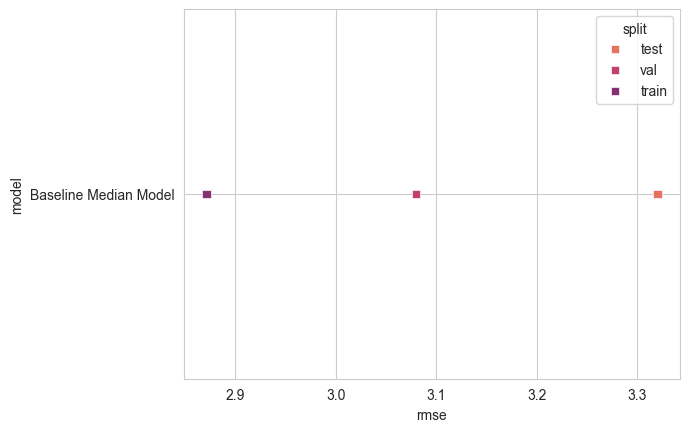

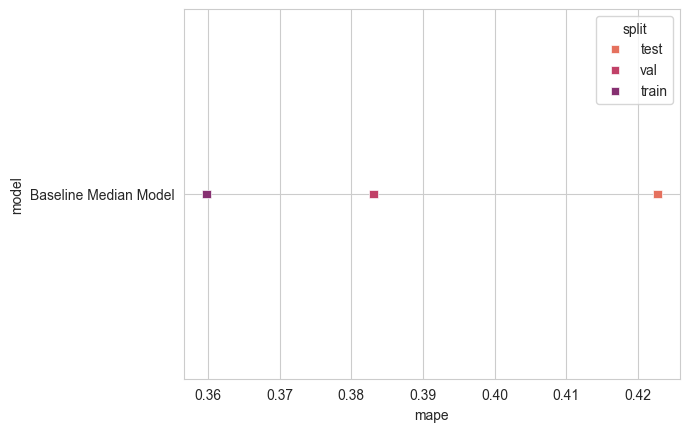

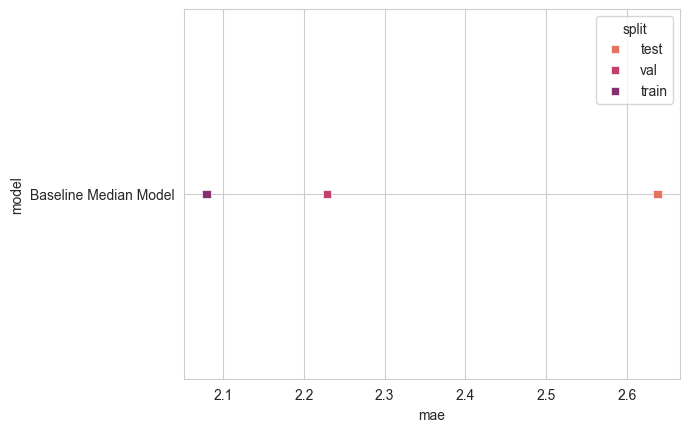

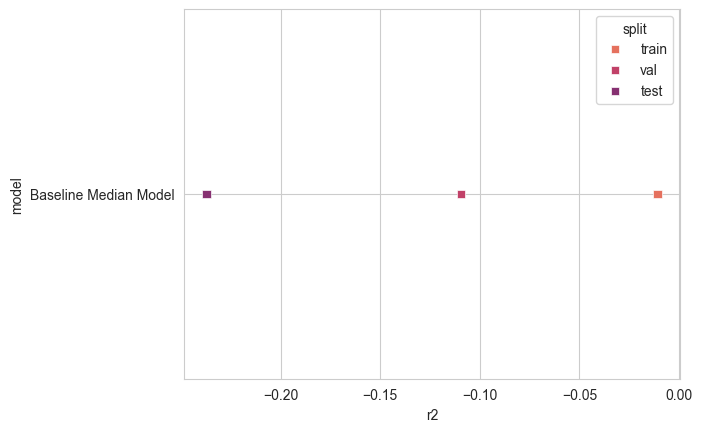

In [54]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette='flare')
plt.show()


## Simple Linear Model with Demographic Predictors

**Imports and Setup:**
- Imports necessary libraries (`Ridge`, `RidgeCV`, `pandas`, `numpy`, `statsmodels`, `sklearn.metrics`, and `pickle`).
- Defines a range of alpha values for `RidgeCV`.

**RidgeCV:**
- Fits a `RidgeCV` model on demographic predictors (`population`, `Year`, `Size_rank`, `land_area`).
- Selects the best alpha and fits a final `Ridge` model.
- Evaluates the Ridge model using RMSE on test data.

**Simple Linear Regression:**
- Fits a linear regression model on the same demographic predictors.
- Evaluates the model across training, validation, and test datasets, calculating performance metrics (R-squared, RMSE, MAE, MAPE).
- Stores results in a DataFrame and visualizes them using scatter plots.

#### Linear Models with Social and Governance Predictors

**Social Predictors (Voice & Accountability, Health):**
- Adds `WGI VA` and `Health` to demographic predictors.
- Fits and evaluates the linear model, stores, and visualizes performance metrics.

**Full Social Model (Including ICT):**
- Adds `ICT` to the social predictors.
- Fits and evaluates the model, stores, and visualizes performance metrics.

**Governance Predictors (Regulatory Quality, Government Effectiveness, Rule of Law):**
- Adds `WGI RQ`, `WGI GE`, and `WGI RL` to demographic predictors.
- Fits and evaluates the model, stores, and visualizes performance metrics.

**Full Governance Model (Including Political Stability, Control of Corruption):**
- Adds `WGI PS` and `WGI CC` to the governance predictors.
- Fits and evaluates the model, stores, and visualizes performance metrics.

## Mixed Effects Linear Regressor (MERF)

- **Data Preparation**
  - Split datasets into `X_train`, `X_val`, `X_test`, `y_train`, `y_val`, `y_test`
  - Define random effects matrix `Z` using the 'Year' feature
  - Select features for training excluding the target and random effects columns
  - Assign clusters using 'Country Code'

- **Model Training**
  - Instantiate `MERF()` model
  - Fit the model with `X_train_selected`, `Z_train`, `clusters_train`, `y_train`

- **Performance Evaluation**
  - Evaluate on train, validation, and test sets
  - Metrics: RMSE, MAE, MAPE, R2
  - Store and print performance metrics for each dataset split

- **Performance Visualization**
  - Create scatter plots to visualize RMSE, MAE, MAPE, R2 for different splits using `sns.scatterplot`

- **SHAP Analysis**
  - Calculate SHAP values for the fixed effects model
  - Plot SHAP summary plot

- **Model Variants**
  - **Government Readiness Model**: Excludes 'Country Code', 'WGI VA', 'ICT', 'Health'
  - **Social Readiness Model**: Excludes 'Country Code', 'WGI PS', 'WGI GE', 'WGI RQ', 'WGI RL', 'WGI CC'

### Ridge CV

In [55]:
from sklearn.linear_model import Ridge, RidgeCV
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import pickle as pkl

In [56]:
alphas = 10**np.linspace(10,-2,100)*0.5
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area']]

In [57]:
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')#, normalize = True)
ridgecv.fit(X_train_selected, y_train)
ridgecv.alpha_

13280.43891473342

In [58]:
ridge_high = Ridge(ridgecv.alpha_)
ridge_high.fit(X_train_selected, y_train)

X_test_selected = X_test[['population', 'Year', 'Size_rank','land_area']]
np.sqrt(mean_squared_error(y_test, ridge_high.predict(X_test_selected)))

1.1607151673711646

### Fitting the Model

In [59]:
#Now let's fit a linear model with only dempographic variable 
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area']]

reg = LinearRegression().fit(X_train_selected, y_train)

model = 'Simple Size Rank'

for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # select predictors
    x_selected = x[['population', 'Year', 'Size_rank','land_area']]
    preds = reg.predict(x_selected)
    
    # Calculate performance metrics
    r2 = r2_score(y, preds)
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    
    # Append performance metrics to the list
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': round(rmse, 4),
        'r2': round(r2, 4),
        'mae': round(mae, 4),
        'mape': round(mape, 4)
    })

In [60]:
perf_df = pd.DataFrame(performances)

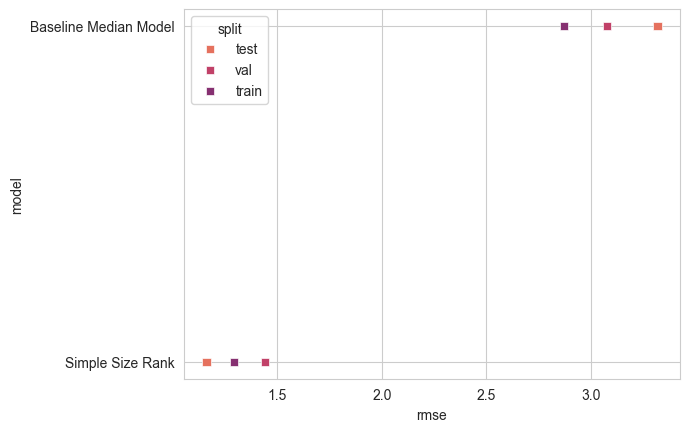

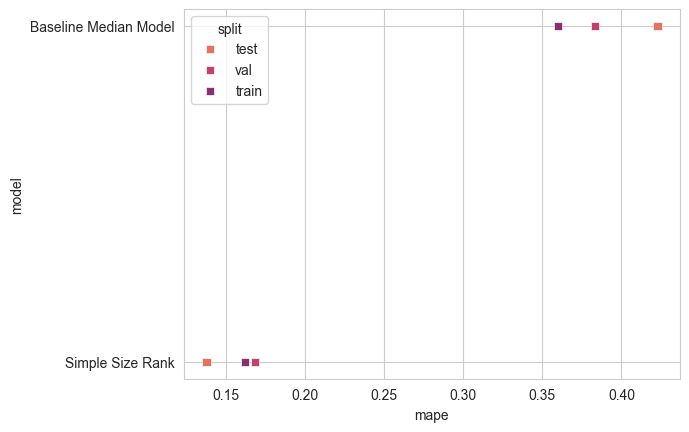

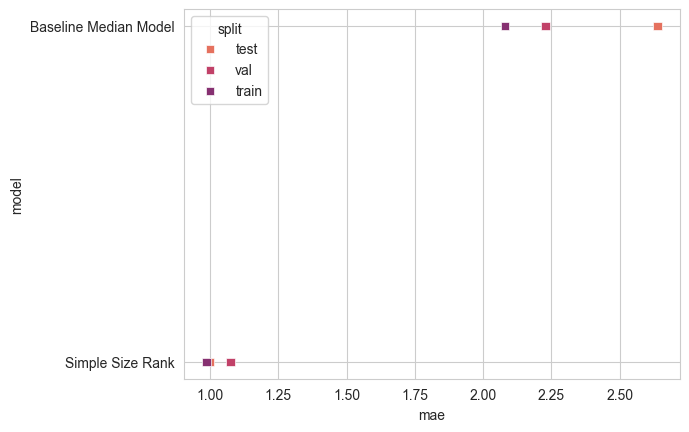

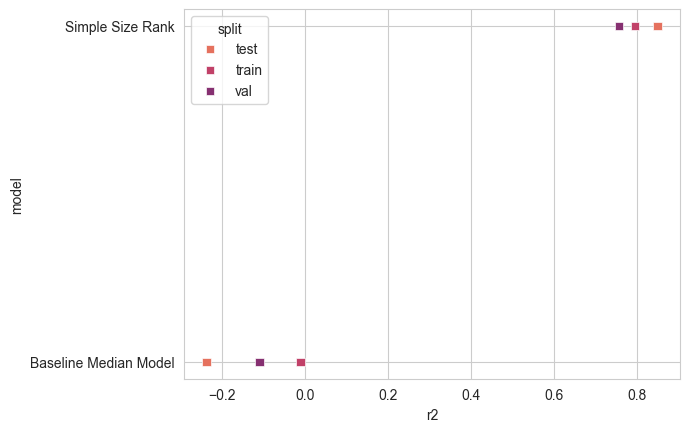

In [61]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

## Linear models with social predictors 

### Theory driven, voice and accaountability and health

In [62]:
#Now let's fit a linear model with only dempographic variable 
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI_va', 'Health']]

reg = LinearRegression().fit(X_train_selected, y_train)

model = 'Social Theory'

for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # select predictors
    x_selected = x[['population', 'Year', 'Size_rank','land_area', 'WGI_va', 'Health']]
    preds = reg.predict(x_selected)
    
    # Calculate performance metrics
    r2 = r2_score(y, preds)
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    
    # Append performance metrics to the list
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': round(rmse, 4),
        'r2': round(r2, 4),
        'mae': round(mae, 4),
        'mape': round(mape, 4)
    })

In [63]:
perf_df = pd.DataFrame(performances)

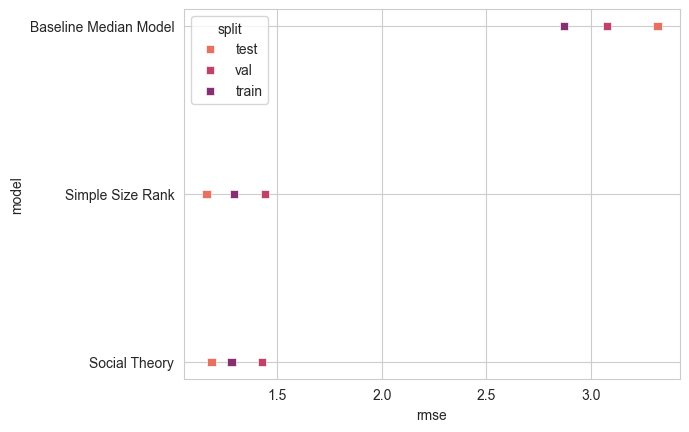

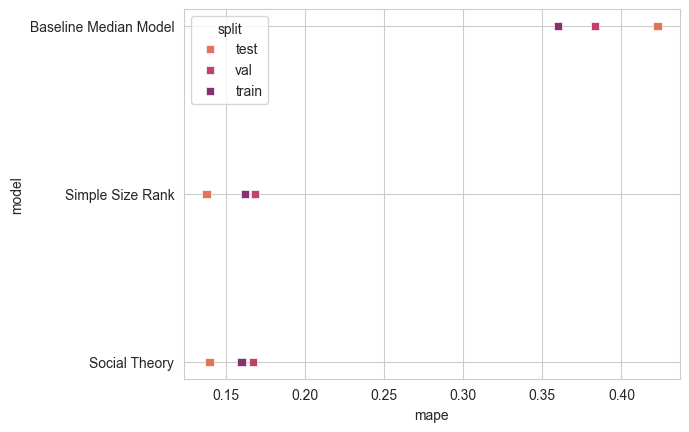

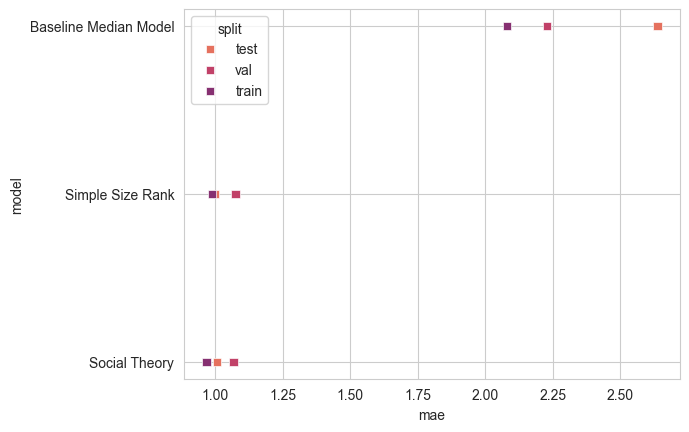

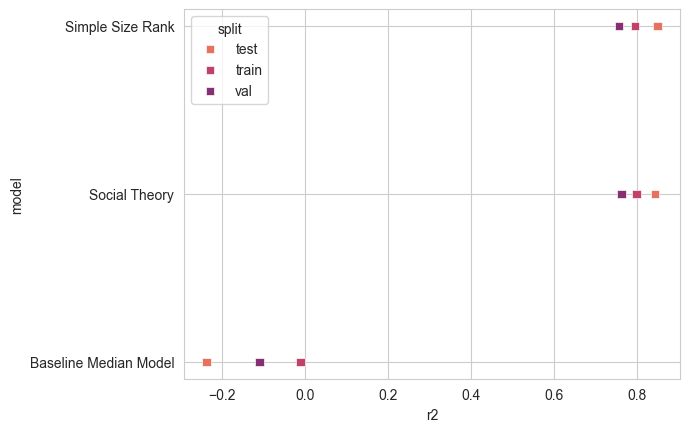

In [64]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

### Full social model including ICT 

In [65]:
#Now let's fit a linear model with only dempographic variable 
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI_va', 'Health', 'ICT']]

reg = LinearRegression().fit(X_train_selected, y_train)

model = 'Social Full'

for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # select predictors
    x_selected = x[['population', 'Year', 'Size_rank','land_area', 'WGI_va', 'Health', 'ICT']]
    preds = reg.predict(x_selected)
    
    # Calculate performance metrics
    r2 = r2_score(y, preds)
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    
    # Append performance metrics to the list
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': round(rmse, 4),
        'r2': round(r2, 4),
        'mae': round(mae, 4),
        'mape': round(mape, 4)
    })

In [66]:
perf_df = pd.DataFrame(performances)

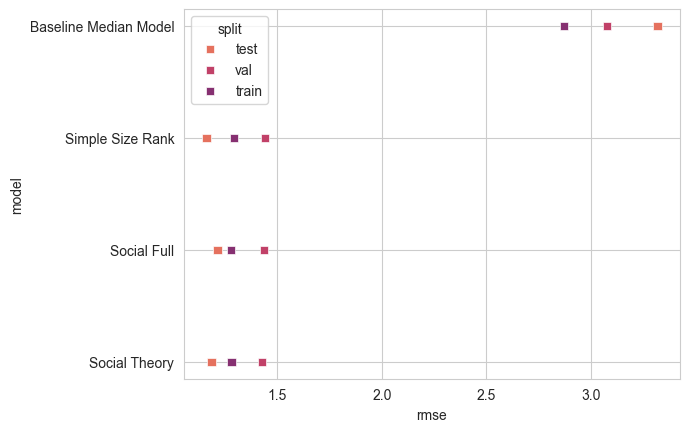

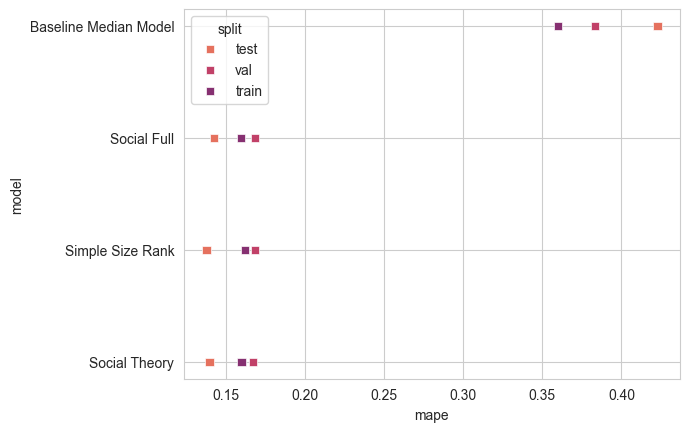

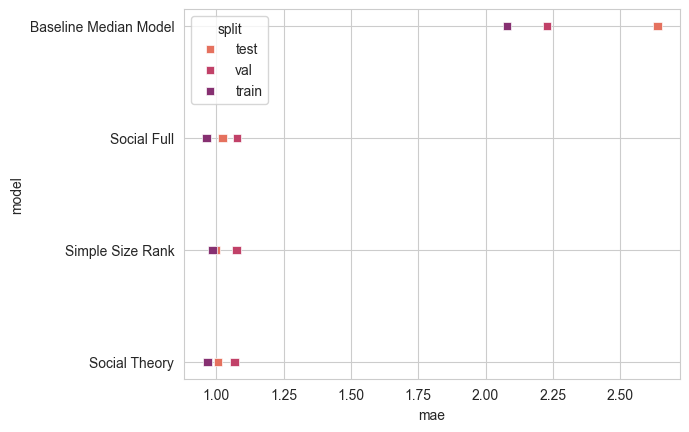

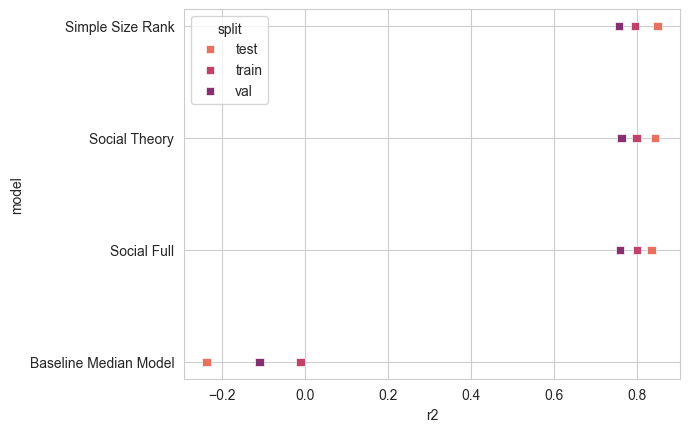

In [67]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

## Linear models with governance predictors 

### Theory driven: regulatory quality, government effectiveness, and rule of law

In [68]:
#Now let's fit a linear model with only dempographic variable 
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI_rq', 'WGI_ge', 'WGI_rl']]

reg = LinearRegression().fit(X_train_selected, y_train)

model = 'Governance Theory'

for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # select predictors
    x_selected = x[['population', 'Year', 'Size_rank','land_area', 'WGI_rq', 'WGI_ge', 'WGI_rl']]
    preds = reg.predict(x_selected)
    
    # Calculate performance metrics
    r2 = r2_score(y, preds)
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    
    # Append performance metrics to the list
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': round(rmse, 4),
        'r2': round(r2, 4),
        'mae': round(mae, 4),
        'mape': round(mape, 4)
    })

In [69]:
perf_df = pd.DataFrame(performances)

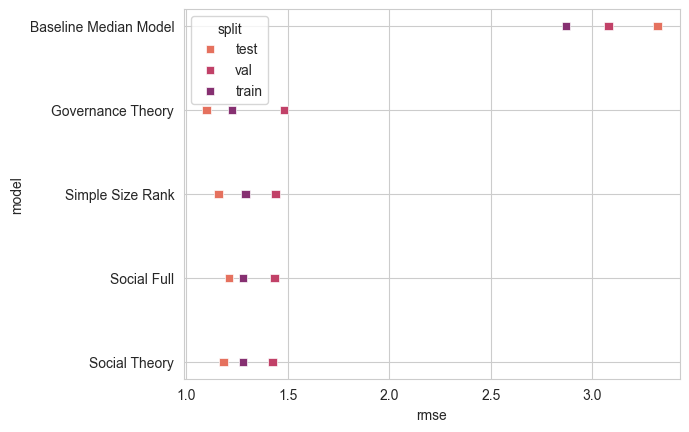

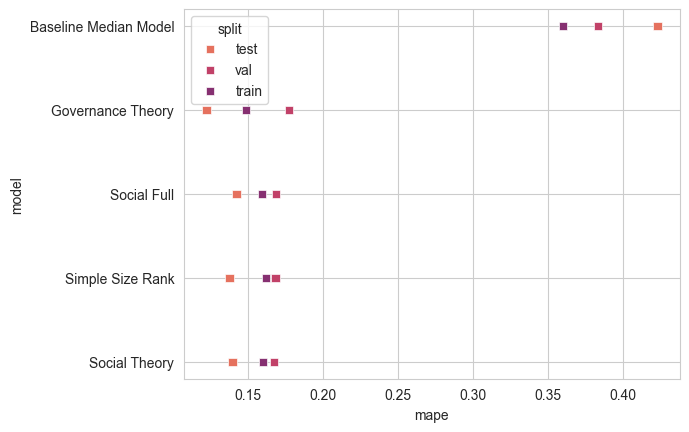

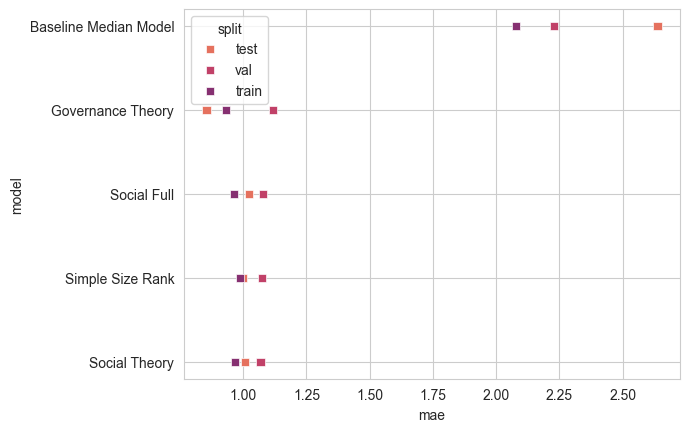

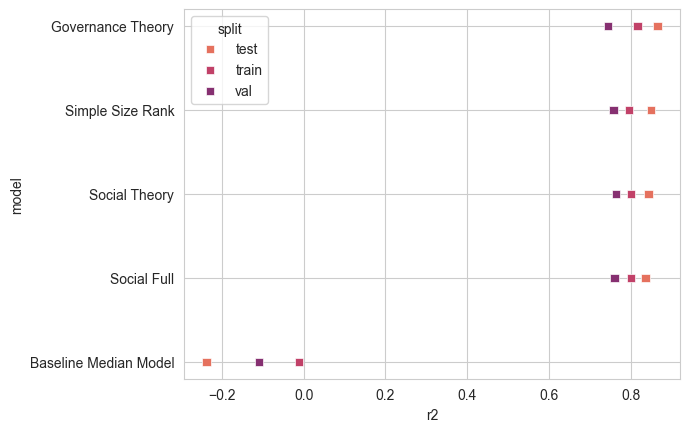

In [70]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

### Full model including political stability and control of corruption 

In [71]:
#Now let's fit a linear model with only dempographic variable 
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI_rq', 'WGI_ge', 'WGI_rl', 'WGI_ps', 'WGI_cc']]

reg = LinearRegression().fit(X_train_selected, y_train)

model = 'Governance Full'

for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # select predictors
    x_selected = x[['population', 'Year', 'Size_rank','land_area', 'WGI_rq', 'WGI_ge', 'WGI_rl', 'WGI_ps', 'WGI_cc']]
    preds = reg.predict(x_selected)
    
    # Calculate performance metrics
    r2 = r2_score(y, preds)
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    
    # Append performance metrics to the list
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': round(rmse, 4),
        'r2': round(r2, 4),
        'mae': round(mae, 4),
        'mape': round(mape, 4)
    })

In [72]:
perf_df = pd.DataFrame(performances)

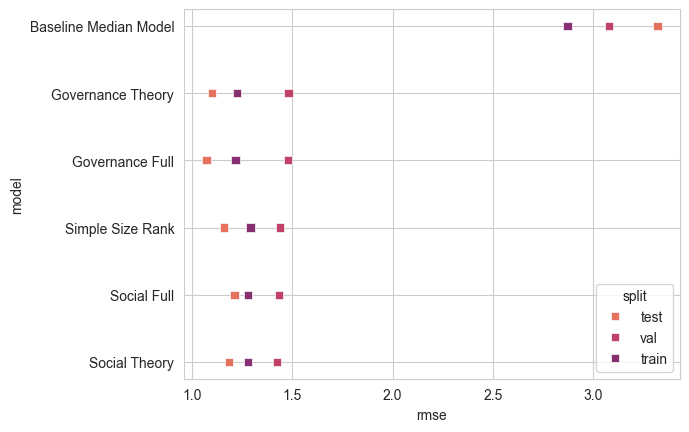

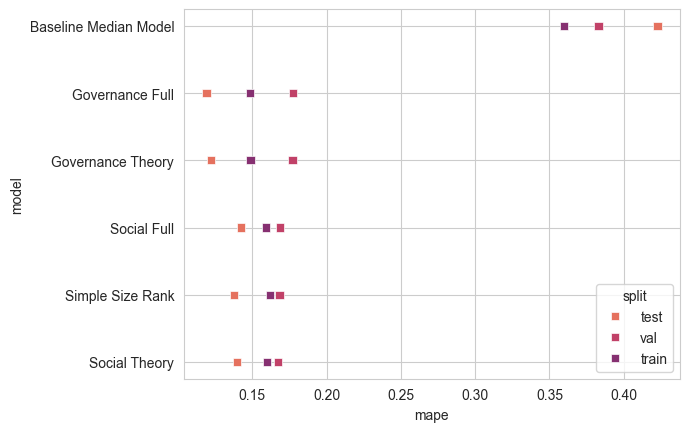

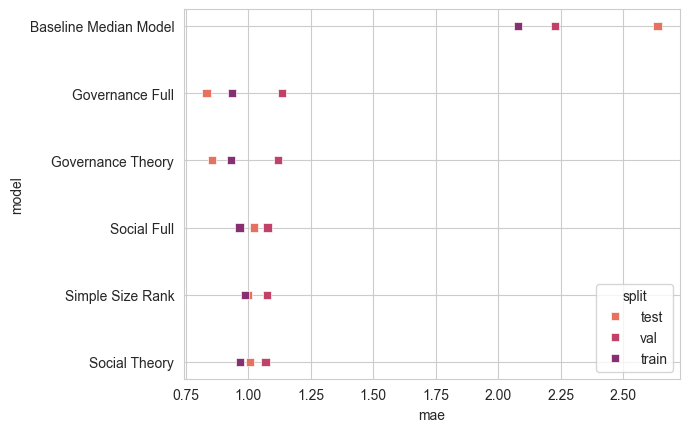

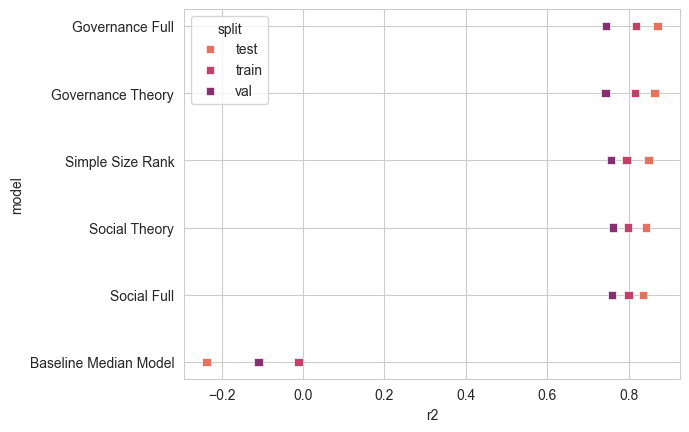

In [73]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

## Mixed Effects Linear Regressor (MERF)

- **Data Preparation**
  - Split datasets into `X_train`, `X_val`, `X_test`, `y_train`, `y_val`, `y_test`
  - Define random effects matrix `Z` using the 'Year' feature
  - Select features for training excluding the target and random effects columns
  - Assign clusters using 'Country Code'

- **Model Training**
  - Instantiate `MERF()` model
  - Fit the model with `X_train_selected`, `Z_train`, `clusters_train`, `y_train`

- **Performance Evaluation**
  - Evaluate on train, validation, and test sets
  - Metrics: RMSE, MAE, MAPE, R2
  - Store and print performance metrics for each dataset split

- **Performance Visualization**
  - Create scatter plots to visualize RMSE, MAE, MAPE, R2 for different splits using `sns.scatterplot`

- **SHAP Analysis**
  - Calculate SHAP values for the fixed effects model
  - Plot SHAP summary plot

- **Model Variants**
  - **Government Readiness Model**: Excludes 'Country Code', 'WGI VA', 'ICT', 'Health'
  - **Social Readiness Model**: Excludes 'Country Code', 'WGI PS', 'WGI GE', 'WGI RQ', 'WGI RL', 'WGI CC'

In [74]:
import merf
from merf import MERF
import numpy as np
import pickle as pkl
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import shap

c:\Users\marc1\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Combined MERF Model

In [76]:
model = 'MERF Full'

# Example for random effects matrix Z (this should be your actual random effects data)
Z_train = X_train['Year'].values.reshape(-1, 1)
Z_val = X_val['Year'].values.reshape(-1, 1)
Z_test = X_test['Year'].values.reshape(-1, 1)

X_train_selected = X_train.drop(columns=['Country Code', 'Size_rank', 'median_prediction', 'log_lagged_agro'])

# Assign country codes as cluster labels
clusters_train = X_train['Country Code']

# Fit the MERF model
merf = MERF()
merf.fit(X_train_selected, Z_train, clusters_train, y_train)

# Evaluate the model on train, validation, and test sets
for x, z, y, nsplit, name in zip([X_train, X_val, X_test], [Z_train, Z_val, Z_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    # Remove 'Country Code' feature from the input data
    x_selected = x.drop(columns=['Country Code', 'Size_rank', 'median_prediction', 'log_lagged_agro'])
    
    # Define clusters based on country codes
    clusters = x['Country Code']
    
    # Predict using the MERF model
    preds = merf.predict(x_selected, z, clusters)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': rmse.round(4),
        'mae': mae.round(4),
        'mape': mape.round(4),
        'r2': r2.round(4)})

# Print the performance metrics
#for performance in performances:
#    print(performance)

INFO     [merf.py:307] Training GLL is -7268.289726934036 at iteration 1.
INFO     [merf.py:307] Training GLL is -12248.043885162571 at iteration 2.
INFO     [merf.py:307] Training GLL is -13682.473162911569 at iteration 3.
INFO     [merf.py:307] Training GLL is -13635.004878411452 at iteration 4.
INFO     [merf.py:307] Training GLL is -13740.694575484446 at iteration 5.
INFO     [merf.py:307] Training GLL is -13878.540964994421 at iteration 6.
INFO     [merf.py:307] Training GLL is -14090.120438162458 at iteration 7.
INFO     [merf.py:307] Training GLL is -14270.050749445627 at iteration 8.
INFO     [merf.py:307] Training GLL is -14256.321007303199 at iteration 9.
INFO     [merf.py:307] Training GLL is -14227.429160657342 at iteration 10.
INFO     [merf.py:307] Training GLL is -14170.318176233206 at iteration 11.
INFO     [merf.py:307] Training GLL is -14478.401709596266 at iteration 12.
INFO     [merf.py:307] Training GLL is -14505.103856174803 at iteration 13.
INFO     [merf.py:307]

In [77]:
perf_df = pd.DataFrame(performances)

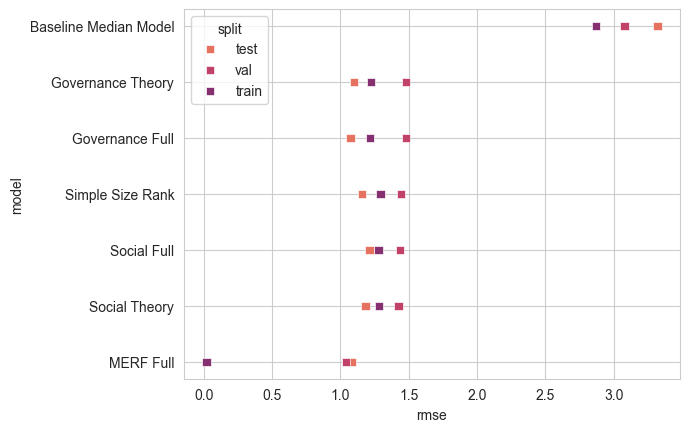

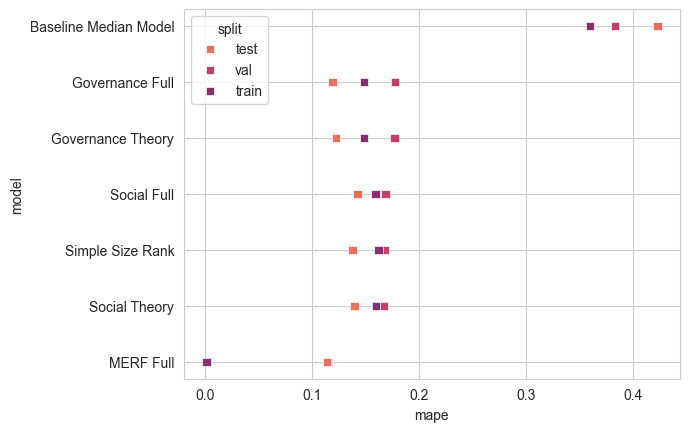

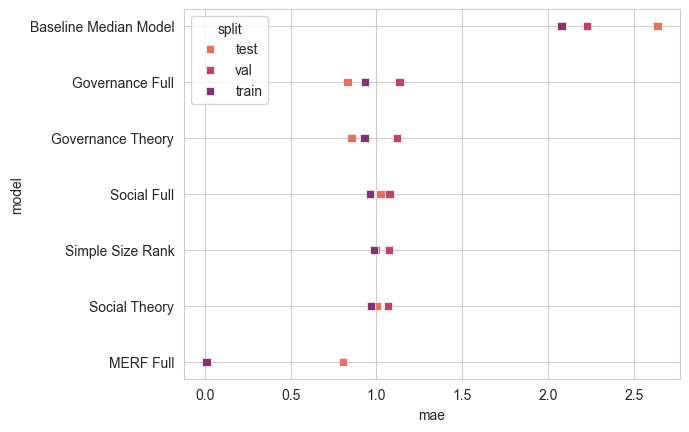

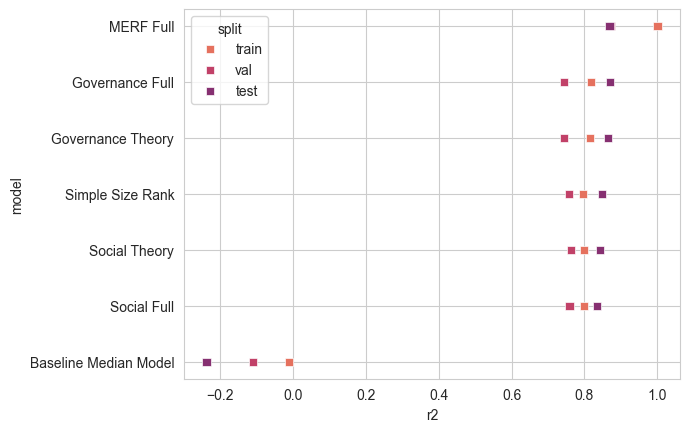

In [78]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

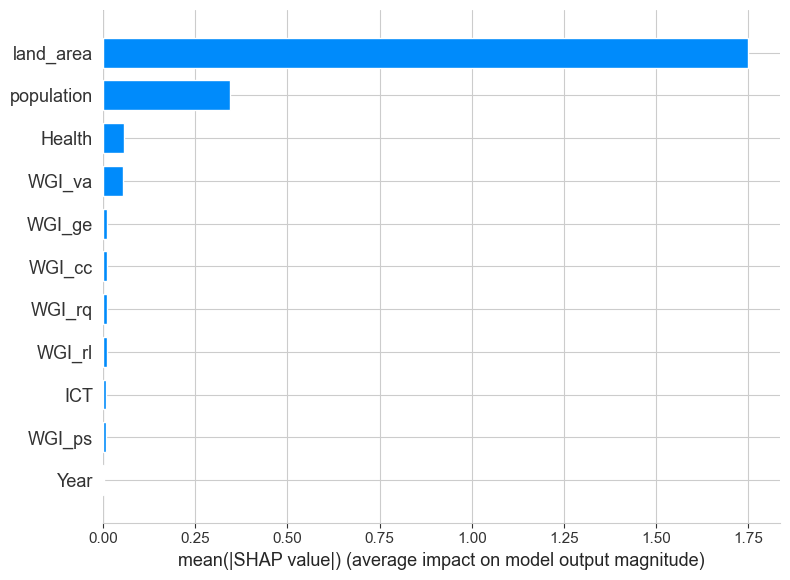

In [79]:
# Calculate SHAP values
explainer = shap.TreeExplainer(merf.trained_fe_model)  # Assuming the fixed effects model is a tree-based model
shap_values = explainer.shap_values(X_train_selected)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train_selected, plot_type="bar")

### Governmental Readiness MERF Model

In [80]:
# Define the model name
model = "Government MERF"

# Example for random effects matrix Z (this should be your actual random effects data)
Z_train = X_train['Year'].values.reshape(-1, 1)
Z_val = X_val['Year'].values.reshape(-1, 1)
Z_test = X_test['Year'].values.reshape(-1, 1)

X_train_selected = X_train.drop(columns=['Country Code', 'WGI_va', 'ICT', 'Health', 'Size_rank', 'median_prediction', 'log_lagged_agro'])

# Assign country codes as cluster labels
clusters_train = X_train['Country Code']

# Fit the MERF model
merf = MERF()
merf.fit(X_train_selected, Z_train, clusters_train, y_train)

# Evaluate the model on train, validation, and test sets
for x, z, y, nsplit, name in zip([X_train, X_val, X_test], [Z_train, Z_val, Z_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    # Remove 'Country Code' feature from the input data
    x_selected = x.drop(columns=['Country Code', 'WGI_va', 'ICT', 'Health', 'Size_rank', 'median_prediction', 'log_lagged_agro'])
    
    # Define clusters based on country codes
    clusters = x['Country Code']
    
    # Predict using the MERF model
    preds = merf.predict(x_selected, z, clusters)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': rmse.round(4),
        'mae': mae.round(4),
        'mape': mape.round(4),
        'r2': r2.round(4)})

# Print the performance metrics
#for performance in performances:
#    print(performance)

INFO     [merf.py:307] Training GLL is -7252.633498707832 at iteration 1.
INFO     [merf.py:307] Training GLL is -12036.748185094864 at iteration 2.
INFO     [merf.py:307] Training GLL is -13054.41559646925 at iteration 3.
INFO     [merf.py:307] Training GLL is -13341.724177688186 at iteration 4.
INFO     [merf.py:307] Training GLL is -13256.408444592429 at iteration 5.
INFO     [merf.py:307] Training GLL is -13372.523349364577 at iteration 6.
INFO     [merf.py:307] Training GLL is -13623.588329526765 at iteration 7.
INFO     [merf.py:307] Training GLL is -13690.748515493746 at iteration 8.
INFO     [merf.py:307] Training GLL is -13838.132480346878 at iteration 9.
INFO     [merf.py:307] Training GLL is -14034.687146849275 at iteration 10.
INFO     [merf.py:307] Training GLL is -13910.886424976692 at iteration 11.
INFO     [merf.py:307] Training GLL is -14121.236787258238 at iteration 12.
INFO     [merf.py:307] Training GLL is -14217.312381901993 at iteration 13.
INFO     [merf.py:307] 

In [81]:
perf_df = pd.DataFrame(performances)

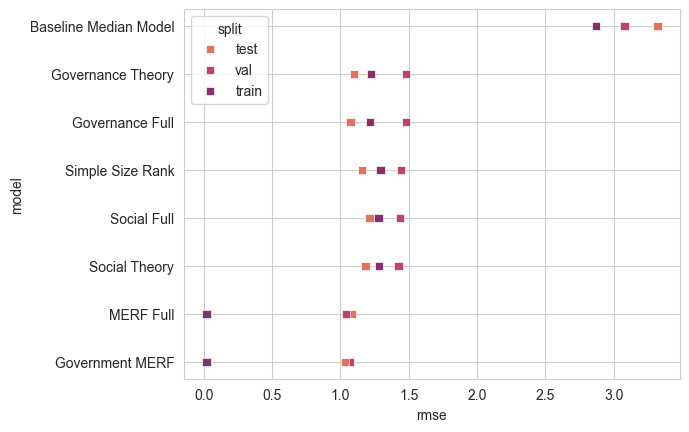

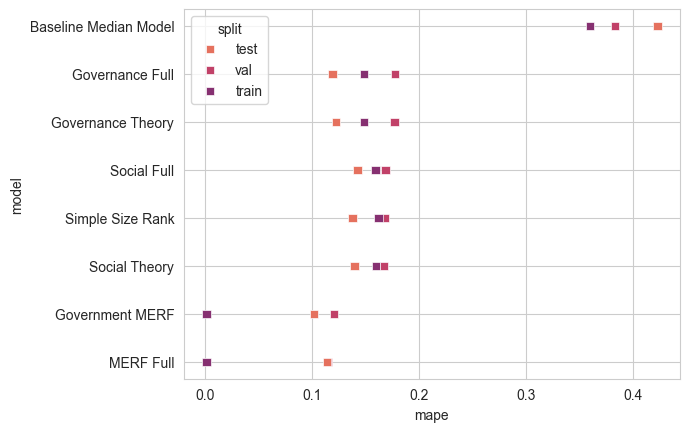

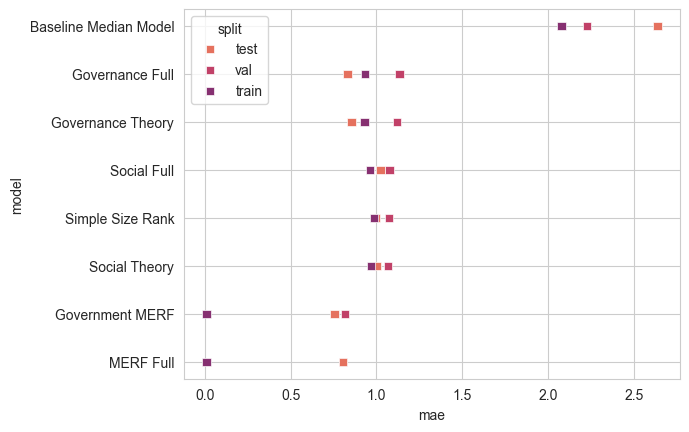

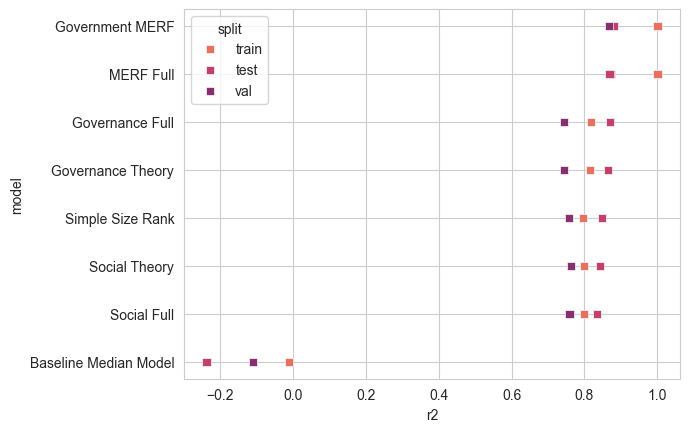

In [82]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

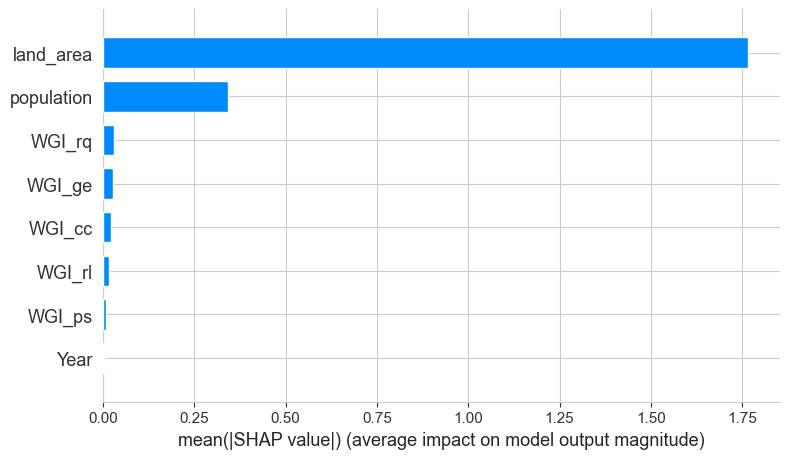

In [83]:
# Calculate SHAP values
explainer = shap.TreeExplainer(merf.trained_fe_model)  # Assuming the fixed effects model is a tree-based model
shap_values = explainer.shap_values(X_train_selected)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train_selected, plot_type="bar")

### Social Readiness MERF Model

In [84]:
# Define the model name
model = "Social MERF"

# Example for random effects matrix Z (this should be your actual random effects data)
Z_train = X_train['Year'].values.reshape(-1, 1)
Z_val = X_val['Year'].values.reshape(-1, 1)
Z_test = X_test['Year'].values.reshape(-1, 1)

X_train_selected = X_train.drop(columns=['Country Code', 'WGI_ps','WGI_ge','WGI_rq','WGI_rl','WGI_cc', 'Size_rank', 'median_prediction', 'log_lagged_agro'])

# Assign country codes as cluster labels
clusters_train = X_train['Country Code']

# Fit the MERF model
merf = MERF()
merf.fit(X_train_selected, Z_train, clusters_train, y_train)

# Evaluate the model on train, validation, and test sets
for x, z, y, nsplit, name in zip([X_train, X_val, X_test], [Z_train, Z_val, Z_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    # Remove 'Country Code' feature from the input data
    x_selected = x.drop(columns=['Country Code', 'WGI_ps','WGI_ge','WGI_rq','WGI_rl','WGI_cc', 'Size_rank', 'median_prediction', 'log_lagged_agro'])

    # Define clusters based on country codes
    clusters = x['Country Code']
    
    # Predict using the MERF model
    preds = merf.predict(x_selected, z, clusters)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': rmse.round(4),
        'mae': mae.round(4),
        'mape': mape.round(4),
        'r2': r2.round(4)})

# Print the performance metrics
#for performance in performances:
#    print(performance)

INFO     [merf.py:307] Training GLL is -7276.277899959071 at iteration 1.
INFO     [merf.py:307] Training GLL is -12289.378298269636 at iteration 2.
INFO     [merf.py:307] Training GLL is -13930.233548246802 at iteration 3.
INFO     [merf.py:307] Training GLL is -13984.360232284203 at iteration 4.
INFO     [merf.py:307] Training GLL is -14018.980593393777 at iteration 5.
INFO     [merf.py:307] Training GLL is -14146.592975998754 at iteration 6.
INFO     [merf.py:307] Training GLL is -14198.218413380266 at iteration 7.
INFO     [merf.py:307] Training GLL is -14044.041675061613 at iteration 8.
INFO     [merf.py:307] Training GLL is -14218.267487919931 at iteration 9.
INFO     [merf.py:307] Training GLL is -14146.74608779027 at iteration 10.
INFO     [merf.py:307] Training GLL is -14369.344777645232 at iteration 11.
INFO     [merf.py:307] Training GLL is -14344.16624622494 at iteration 12.
INFO     [merf.py:307] Training GLL is -14359.889091157109 at iteration 13.
INFO     [merf.py:307] T

In [85]:
perf_df = pd.DataFrame(performances)

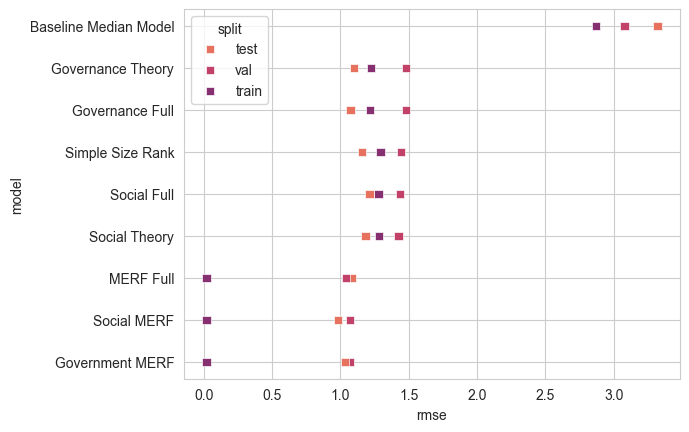

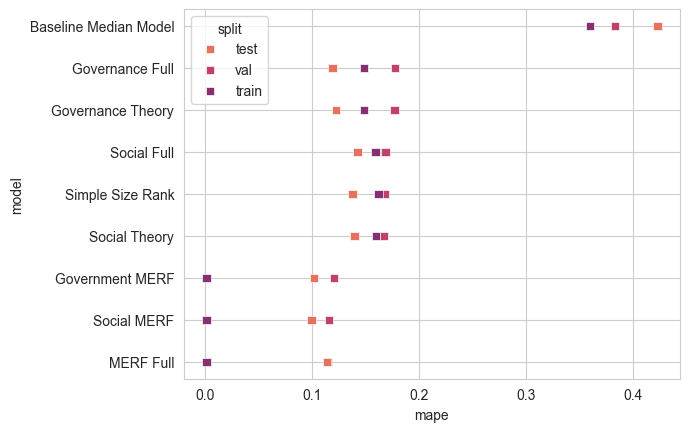

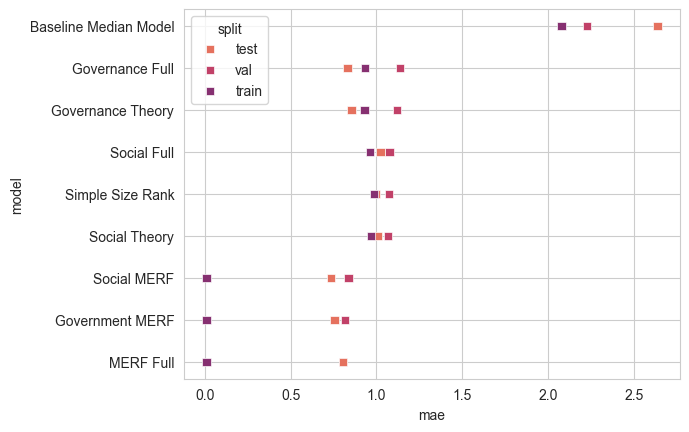

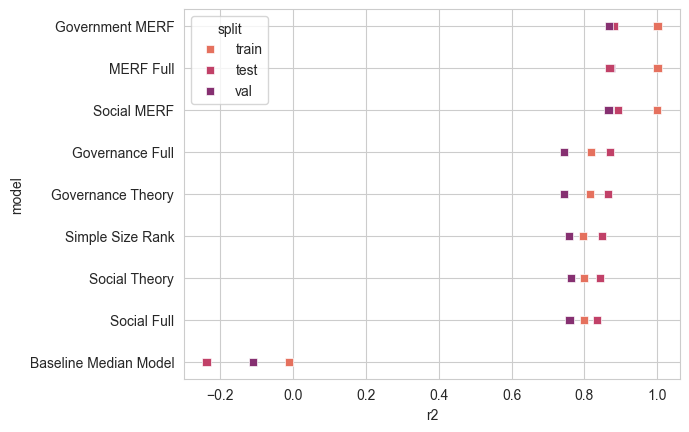

In [86]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

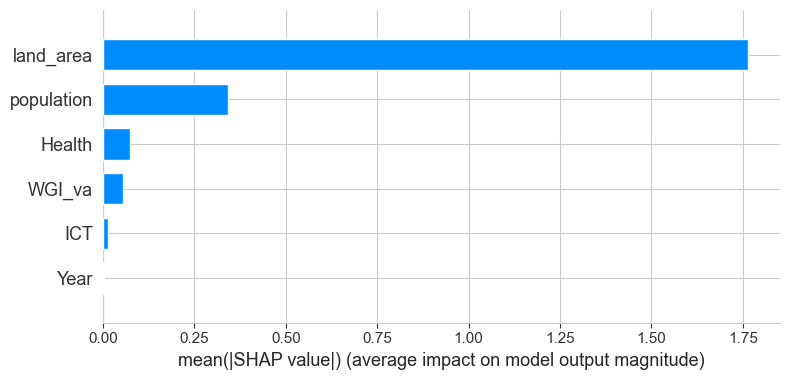

In [87]:
# Calculate SHAP values
explainer = shap.TreeExplainer(merf.trained_fe_model)  # Assuming the fixed effects model is a tree-based model
shap_values = explainer.shap_values(X_train_selected)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train_selected, plot_type="bar")

## Improving the Full Linear Models

In [88]:
from sklearn.linear_model import Ridge, RidgeCV
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import pickle as pkl

### Social Full Model

In [90]:
alphas = 10**np.linspace(10,-2,100)*0.5

X_train_selected = X_train[['population', 'Year', 'Size_rank', 'land_area', 'WGI_va', 'Health', 'ICT']]

ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')#, normalize = True)
ridgecv.fit(X_train_selected, y_train)
best_alpha = ridgecv.alpha_

In [91]:
ridge_high = Ridge(alpha=best_alpha)
ridge_high.fit(X_train_selected, y_train)

c:\Users\marc1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.49321e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge(alpha=66.09705742330144)

In [93]:
model = 'Ridge Social Full'

for x, y, nsplit in zip([X_train, X_val, X_test], [y_train, y_val, y_test], ['train', 'val', 'test']):
    # Select predictors
    x_selected = x[['population', 'Year', 'Size_rank','land_area', 'WGI_va', 'Health', 'ICT']]
    preds = ridge_high.predict(x_selected)
    
    # Calculate performance metrics
    r2 = r2_score(y, preds)
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    
    # Append performance metrics to the list
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': round(rmse, 4),
        'r2': round(r2, 4),
        'mae': round(mae, 4),
        'mape': round(mape, 4)
    })

In [94]:
perf_df = pd.DataFrame(performances)

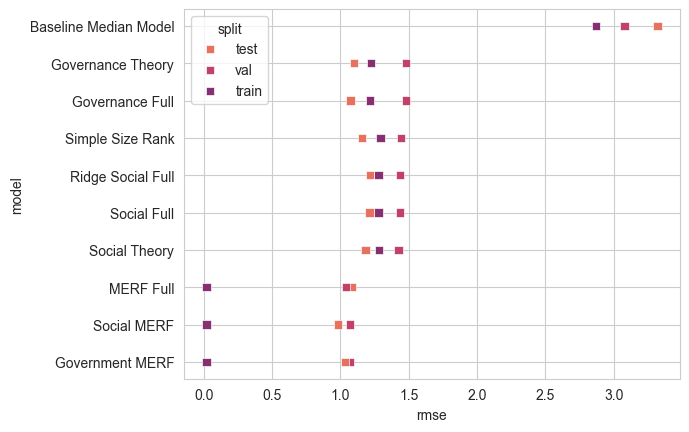

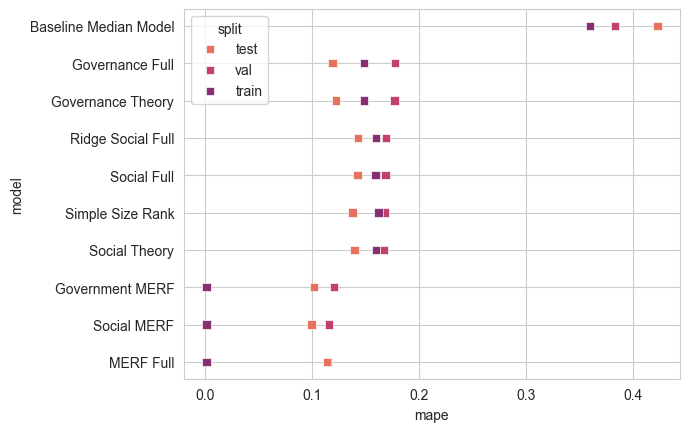

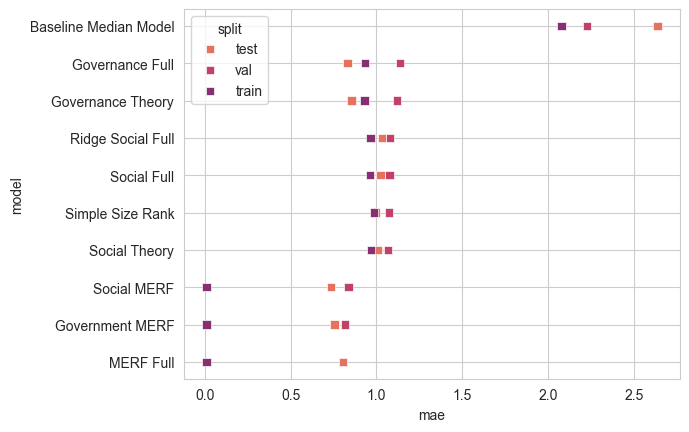

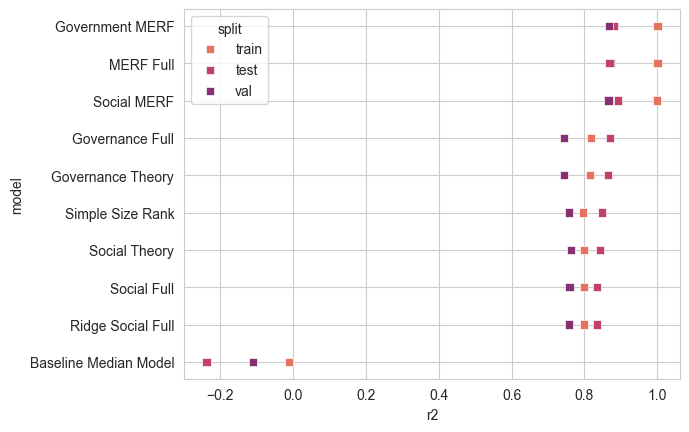

In [95]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

### Government Full Model

In [96]:
alphas = 10**np.linspace(10,-2,100)*0.5

X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI_rq', 'WGI_ge', 'WGI_rl', 'WGI_ps', 'WGI_cc']]

ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')#, normalize = True)
ridgecv.fit(X_train_selected, y_train)
best_alpha = ridgecv.alpha_

In [97]:
ridge_high = Ridge(alpha=best_alpha)
ridge_high.fit(X_train_selected, y_train)

c:\Users\marc1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.19465e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge(alpha=5.361336110051605)

In [98]:
model = 'Ridge Governance Full'

for x, y, nsplit in zip([X_train, X_val, X_test], [y_train, y_val, y_test], ['train', 'val', 'test']):
    # Select predictors
    x_selected = x[['population', 'Year', 'Size_rank','land_area', 'WGI_rq', 'WGI_ge', 'WGI_rl', 'WGI_ps', 'WGI_cc']]
    preds = ridge_high.predict(x_selected)
    
    # Calculate performance metrics
    r2 = r2_score(y, preds)
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    
    # Append performance metrics to the list
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': round(rmse, 4),
        'r2': round(r2, 4),
        'mae': round(mae, 4),
        'mape': round(mape, 4)
    })

In [99]:
perf_df = pd.DataFrame(performances)

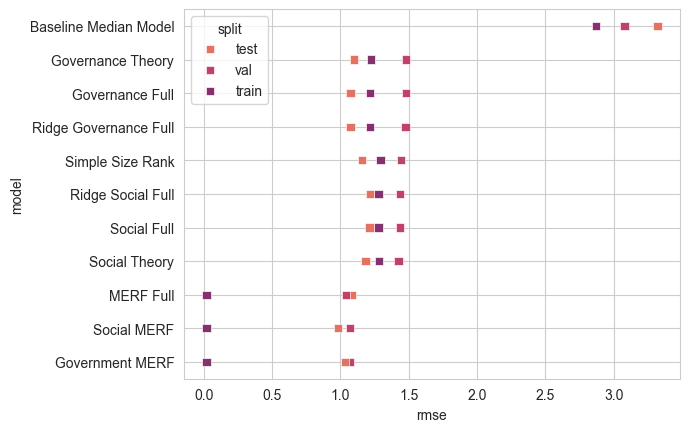

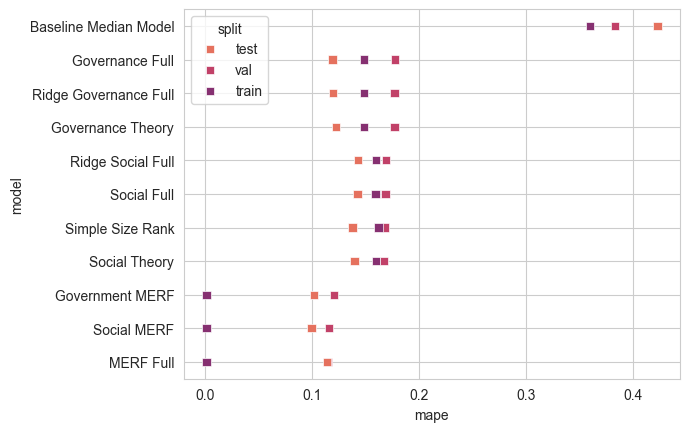

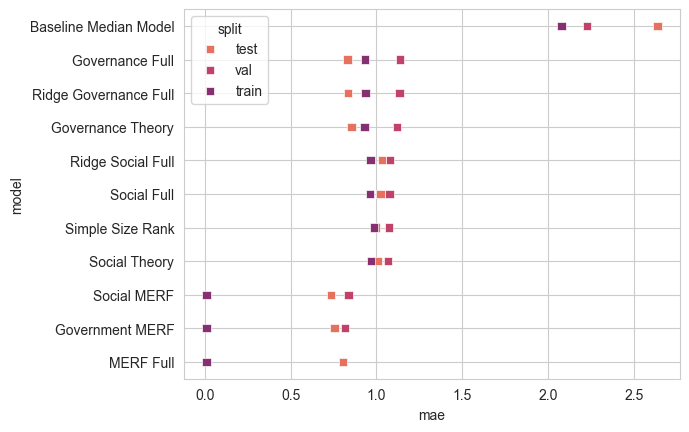

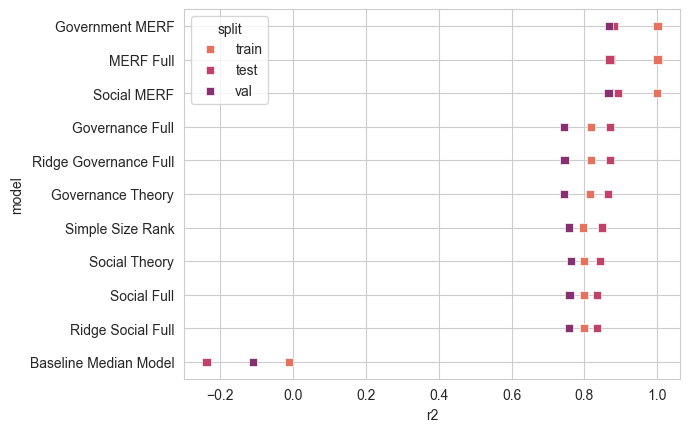

In [100]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette='flare')
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette='flare')
plt.show()